In [27]:
"""
Created on Tue Dec  3 13:03:17 2024

@author: Marcin Plodzien
"""
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
import scipy.sparse as sp
import pandas as pd
import time
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
# Parameters
n_max = 3  # Maximum occupation number per site
L = 2  # Number of sites in the lattice
U = 1.0  # On-site interaction strength
mu_values = np.linspace(0., 1, 10)  # Range of chemical potentials (mu/U)
J_U_values = np.linspace(0, 0.06, 10)  # Range of J/U (hopping strength relative to U)
neighbours_range = 1#L  # Cluster neighbor range
discard_simple_neighbours = True
max_cluster_size = None # None  # Set None for unrestricted cluster size
symmetry_breaking_field = 0*1e-9  # Small perturbation to break symmetry
max_iterations = 1 # Maximum iterations for self-consistency
tolerance = 1e-5 # Convergence tolerance
initial_phi = 1e-3

try:
    a, a_dagger, n_op = boson_operators(n_max, sparsify=True)
except:
    pass

In [5]:

# Bosonic operators
def boson_operators(n_max, sparsify=True):
    dim = n_max + 1
    a = np.zeros((dim, dim), dtype=np.complex128)
    for n in range(1, dim):
        a[n - 1, n] = np.sqrt(n)
    a_dagger = a.T.conj()
    n_op = np.dot(a_dagger, a)
    if sparsify:
        a = sp.bsr_array(a)
        a_dagger = sp.bsr_array(a_dagger)
        n_op = sp.bsr_array(n_op)
    return a, a_dagger, n_op

a, a_dagger, n_op = boson_operators(n_max, sparsify=True)

# Kronecker product
def kron_all_dense(operators):
    result = operators[0]
    for op in operators[1:]:
        result = np.kron(result, op)
    return result
def kron_all(operators, sparse=True):
    #input can be dense
    if not sparse:
        return kron_all_dense(operators)
    
    result = sp.bsr_array(operators[0])
    for op in operators[1:]:
        result = sp.kron(result, sp.bsr_array(op))
    return result
# Initialize clusters
def initialize_clusters(G, neighbours_range, max_cluster_size=None, n_max=3, discard_simple_neighbours=False):
    clusters = {}
    cluster_info = []
    cluster_adj_matrices = {}

    for node in G.nodes():
        # Handle the special case where neighbours_range = 0
        if neighbours_range == 0:
            cluster_nodes = [node]
        else:
            # Find neighbors within the specified range
            cluster_nodes = set()
            for dist in range(1, neighbours_range + 1):
                cluster_nodes.update(nx.single_source_shortest_path_length(G, node, cutoff=dist).keys())
            cluster_nodes = list(cluster_nodes)

            if discard_simple_neighbours and neighbours_range>1:
                #discard neighbours that are further than 1 unit away but only have 1 path
                cluster_nodes_new = []
                for neighbour in cluster_nodes:
                    dist = nx.shortest_path_length(G, source=node, target=neighbour)
                    if dist>1 and len(list(nx.all_simple_paths(G, source=node, target=neighbour, cutoff=dist))) < 2:
                        pass
                    else:
                        cluster_nodes_new.append(neighbour)
                cluster_nodes = cluster_nodes_new


        # Limit the cluster size if specified
        if max_cluster_size:
            cluster_nodes = cluster_nodes[:max_cluster_size]

        # Store the cluster in the dictionary
        clusters[node] = cluster_nodes

        # Compute cluster properties
        cluster_size = len(cluster_nodes)
        hilbert_space_size = (n_max + 1) ** cluster_size

        # Create a subgraph for the cluster and extract the adjacency matrix
        subgraph = G.subgraph(cluster_nodes)
        adj_matrix = nx.adjacency_matrix(subgraph).toarray()
        cluster_adj_matrices[node] = adj_matrix

        # Append information to the DataFrame
        cluster_info.append({
            "Central Node": node,
            "Cluster Nodes": cluster_nodes,
            "Cluster Size": cluster_size,
            "Cluster Hilbert Space Dimension": hilbert_space_size
        })

    # Create a pandas DataFrame from the cluster information
    cluster_df = pd.DataFrame(cluster_info)

    return clusters, cluster_df, cluster_adj_matrices

# Generate site-wise operators

def generate_site_operators(cluster_size, n_max):
    identity = sp.bsr_array(np.eye(n_max + 1, dtype=np.complex128))
    a_ops, a_dagger_ops, n_ops = [], [], []
    for site in range(cluster_size):
        ops = [identity] * cluster_size
        ops[site] = a
        a_ops.append(kron_all(ops))
        ops[site] = a_dagger
        a_dagger_ops.append(kron_all(ops))
        ops[site] = n_op
        n_ops.append(kron_all(ops))
    return a_ops, a_dagger_ops, n_ops
def generate_site_t_creation(cluster_size,n_max,t):
    identity = sp.bsr_array(np.eye(n_max + 1, dtype=np.complex128))
    ops = [identity] * cluster_size
    ops[t] = a_dagger
    return kron_all(ops)
# Construct Hamiltonian for a cluster
def construct_H_cluster(U, mu, J, Phi_cluster_list, cluster_nodes, adj_matrix, n_max, h):
    if type(cluster_nodes) == int:    
        cluster_size = cluster_nodes
    else:
        cluster_size = len(cluster_nodes)
    dim = (n_max + 1) ** cluster_size
    H = sp.bsr_array((dim, dim), dtype=np.complex128)

    # Generate site-wise operators
    a_ops, a_dagger_ops, n_ops = generate_site_operators(cluster_size, n_max)
    #print(H.shape, n_ops[0].shape,sp.bsr_array(np.eye(dim)).shape)
    # On-site terms
    for i in range(cluster_size):
        H += (U / 2) * n_ops[i] @ (n_ops[i] - sp.identity(dim, dtype = np.complex128)) - mu * n_ops[i]

    # Hopping terms within the cluster
    for i in range(cluster_size):
        for j in range(cluster_size):
            if adj_matrix[i, j] == 1:  # Use local adjacency matrix
                #H -= J * (a_dagger_ops[i] @ a_ops[j] + a_ops[i] @ a_dagger_ops[j])
                H -= J * a_dagger_ops[i] @ a_ops[j]

    # Mean-field contribution from neighboring clusters
    for i in range(cluster_size):
        H -= J * (Phi_cluster_list[i] * a_dagger_ops[i] + np.conj(Phi_cluster_list[i]) * a_ops[i])

    # Symmetry-breaking field
    for i in range(cluster_size):
        H -= h * (a_ops[i] + a_dagger_ops[i])

    return H


def find_MF_overlapping(G, cluster_nodes, phi_C):
    #this function checks each node in cluster_nodes and looks if it is connected to nodes from other clusters
    #phi_C[neighbour] is summed over neigbours from outside the considered cluster  
    ###IMPORTANT: it assumes that every node in G has it's own cluster
    #(alternate approach needed for generalization)

    Phi_cluster_list = np.zeros(len(cluster_nodes), dtype=np.complex128)
    for i,node in enumerate(cluster_nodes):
        neighbours = list(G.neighbors(node))
        #check every neighbor if it is inside our cluster
        for nbr in neighbours:
            if nbr not in cluster_nodes:
                if nbr in phi_C:
                    Phi_cluster_list[i] += phi_C[nbr]
                else:
                    print(f'Error: neighbour {nbr} of site {node} does not have its own cluster')
            #else: Phi_cluster_list[i] += phi_C[nbr]*1 #debug
    return Phi_cluster_list

In [6]:
from math import factorial
def vbasisGen(N,M,max_global_flucs=5,target_filling=1,max_loc_flucs=2):
    #could be faster
    
    def last_nonzero_position(arr):
        # Traverse the array from the end
        for i in range(len(arr) - 1, -1, -1):
            if arr[i] != 0:
                return i
        return -1  # Return -1 if there are no non-zero elements
    D = factorial(N+M-1)//(factorial(N)*factorial(M-1))
    v0 = np.zeros(M,dtype=int)
    v0[0] = N
    vList = []
    vOld = v0
    vNew = vOld.copy()

    if np.sum(np.abs(vNew-target_filling))<=max_global_flucs and np.max(np.abs(vNew-target_filling))<=max_loc_flucs:
            vList.append(vNew.copy())
    
    k=0
    i=1
    while(i<D):
        vNew[k] = vOld[k] - 1
        vNew[k+1] = N - np.sum(vNew[:k+1])
        vNew[k+2:] = 0
        k = last_nonzero_position(vNew)
        if k>M-2:
            k = last_nonzero_position(vNew[:-1])
        if np.sum(np.abs(vNew-target_filling))<=max_global_flucs and np.max(np.abs(vNew-target_filling))<=max_loc_flucs:
            #print(vNew, np.sum(np.abs(vNew-target_filling)), np.max(np.abs(vNew-target_filling)))
            vList.append(vNew.copy())
        vOld = vNew
        i+=1
    return np.array(vList)


def vbasis1D(N,M):
    def last_nonzero_position(arr):
        # Traverse the array from the end
        for i in range(len(arr) - 1, -1, -1):
            if arr[i] != 0:
                return i
        return -1  # Return -1 if there are no non-zero elements
    D = factorial(N+M-1)//(factorial(N)*factorial(M-1))
    v0 = np.zeros(M,dtype=int)
    v0[0] = N
    vList = np.empty((D,M),dtype=int)
    vList[0] = v0
    vOld = v0
    vNew = vOld.copy()
    k=0
    i=1
    while(i<D):
        vNew[k] = vOld[k] - 1
        vNew[k+1] = N - np.sum(vNew[:k+1])
        vNew[k+2:] = 0
        k = last_nonzero_position(vNew)
        if k>M-2:
            k = last_nonzero_position(vNew[:-1])
        #print(vOld,vNew,k,"~~")
        vList[i] = vNew
        vOld = vNew
        i+=1
    return vList
from scipy.sparse import lil_matrix, csr_matrix
def Ttag(v):
    return np.sum(np.sqrt((np.arange(v.shape[0])*100+3))*v)
def TtagL(vL):
    pi = np.sqrt((np.arange(vL.shape[1])*100+3))
    tt = np.array([np.sum( pi*v ) for v in vL])
    ind = np.argsort(tt)
    return tt[ind], ind
def hamFull(adMat,N, J, mu, niu, phi, max_global_flucs=5):
    M = adMat.shape[0]
    vList = vbasisGen(N,M,max_global_flucs=max_global_flucs)
    vList = np.vstack((vList, vbasisGen(N+1,M,max_global_flucs=max_global_flucs)))
    vList = np.vstack((vList, vbasisGen(N-1,M,max_global_flucs=max_global_flucs)))

    Tsort, ind = TtagL(vList)
    
    xs, ys = adMat.nonzero()
    ham_kin = lil_matrix((vList.shape[0],vList.shape[0]))
    for i in range(vList.shape[0]):
        v = vList[i]
        for x,y in np.transpose([xs,ys]):
            if x!=y and v[y]>0:
                newV = v.copy()
                newV[x] += 1
                newV[y] -= 1
                newT = Ttag(newV)
                newIdx = np.searchsorted(Tsort, newT, side='left')
                
                if newIdx<len(Tsort) and Tsort[newIdx] == newT: #DEBUG
                    ham_kin[i,ind[newIdx]] = -J*np.sqrt((v[x]+1)*v[y])
    ham_int = lil_matrix((vList.shape[0],vList.shape[0]))
    for i in range(vList.shape[0]):
        v = vList[i]
        ham_int[i,i] = U/2*np.sum((v-1)*v) - mu*np.sum(v)
    
    ham_MF = lil_matrix((vList.shape[0],vList.shape[0]))
    for site_idx, site_niu in enumerate(niu):
        if site_niu==0: pass
        else:
            for i in range(vList.shape[0]):
                v = vList[i]

                #add particle from bulk
                newV = v.copy()
                newV[site_idx] += 1
                newT = Ttag(newV)
                newIdx = np.searchsorted(Tsort, newT, side='left')
                #the problem with tags is that a new tag can appear between previous tags, so we check:
                if newIdx<len(Tsort) and Tsort[newIdx] == newT:
                #if abs(np.sum(newV)-N)<=1:
                    ham_MF[i,ind[newIdx]] = -J*site_niu*np.sqrt((v[site_idx]+1))*phi

                #remove particle from bulk
                newV = v.copy()
                newV[site_idx] -= 1
                newT = Ttag(newV)
                newIdx = np.searchsorted(Tsort, newT, side='left')
                #again, we check if we didnt go to N-2 #alternatively we could look at abs(np.sum(newV)-N)>1
                if newIdx<len(Tsort) and Tsort[newIdx] == newT:
                #if abs(np.sum(newV)-N)<=1:
                    ham_MF[i,ind[newIdx]] = -J*site_niu*np.sqrt((v[site_idx]))*np.conj(phi)

    ham = ham_kin + ham_int + ham_MF
    return ham.tocsr(), vList, Tsort, ind


def phi_at_site_t(vList,Tsort,ind, gs, t):
    phi =  0
    for i in range(vList.shape[0]):
        v = vList[i]
        Cn = gs[i]
        if v[t] == 0 or Cn==0:
            continue

        #original_value = v[t]
        #v[t] -= 1
        #newT = Ttag(v)
        #v[t] = original_value
        
        newV = v.copy()
        newV[t] -= 1
        newT = Ttag(newV)

        newIdx = np.searchsorted(Tsort, newT, side='left')
        if newIdx<len(Tsort) and Tsort[newIdx] == newT:
            Cm = np.conj(gs[ind[newIdx]])
            phi += Cm*Cn*np.sqrt(v[t])
    return phi


def homogenous_cluster_calculate_phi_full(mu, J, adj_mat, niu, target_node):
    cluster_size = adj_mat.shape[0]
    if len(niu) != cluster_size: print(f'error: niu len {len(niu)} =/= size {cluster_size}')
    phi = initial_phi
    for iteration in range(max_iterations):
        phi_old = phi
        
        start_time = time.time()#
        #assuming filling 1 -> N=cluster_size
        H_C, vList, Tsort, ind = hamFull(adj_mat, cluster_size, J, mu, niu, phi)
        
        #print(f"1 {time.time() - start_time:.2f} seconds")#
        eigenvalues, eigenvectors = eigsh(H_C,k=1,which='SA')
        #print(f"2 {time.time() - start_time:.2f} seconds")#
        ground_state = eigenvectors[:, 0]
        ground_state /= np.linalg.norm(ground_state)

        # Compute superfluid order parameter
        phi = phi_at_site_t(vList, Tsort, ind, ground_state, target_node)
        #print(f"3 {time.time() - start_time:.2f} seconds")
        
        # Check convergence
        max_phi_diff = abs(phi - phi_old)
        if max_phi_diff < tolerance:
            #print(f"Converged after {iteration + 1} iterations")
            break
    phase_diagram_superfluid_mu_J = abs(phi)
    return phase_diagram_superfluid_mu_J#, phase_diagram_dominant_mu_J

In [102]:

def gen_full_basis(N,M, max_global_flucs=5, max_loc_flucs=2, filling=1):
    vList = vbasisGen(N,M,max_global_flucs=max_global_flucs, max_loc_flucs=max_loc_flucs, target_filling=filling)
    vList = np.vstack((vList, vbasisGen(N+1,M,max_global_flucs=max_global_flucs, max_loc_flucs=max_loc_flucs, target_filling=filling)))
    vList = np.vstack((vList, vbasisGen(N-1,M,max_global_flucs=max_global_flucs, max_loc_flucs=max_loc_flucs, target_filling=filling)))
    
    Tsort, ind = TtagL(vList) #TtagL working for different particle numbers?

    return vList, Tsort, ind


def generate_flucs_rec(M, f, value_range, target_sum, current_vector=None, index=0, current_sum=0, current_abs_sum=0):
    """This function returns all possible combinations of vectors of length M with values in value_range, so that:
    -The sum(abs(vector))<=f
    -The sum(vector) == target_sum
    (written by chatGPT but tested somewhat)
    """

    if current_vector is None:
        current_vector = [0] * M  # Initialize vector with zeros

    # Base case: If we have filled the vector, check the conditions
    if index == M:
        if current_sum == target_sum and current_abs_sum <= f:
            yield np.array(current_vector)
        return

    # Explore all possible values from the given range
    for value in value_range:
        new_sum = current_sum + value
        new_abs_sum = current_abs_sum + abs(value)

        # Prune invalid branches early
        if abs(new_sum - target_sum) > max(value_range) * (M - index - 1):  # Remaining positions cannot balance `target_sum`
            continue
        if new_abs_sum > f:  # Absolute sum constraint violated
            continue

        # Update the current vector and recurse
        current_vector[index] = value
        yield from generate_flucs_rec(M, f, value_range, target_sum, current_vector, index + 1, new_sum, new_abs_sum)
        current_vector[index] = 0  # Backtrack


def gen_full_basis_faster(M, max_global_flucs=5, filling=1, max_loc_flucs=2,N_minus=-2,N_plus=3):
    if type(filling) is not int: print("filling needs to be an integer")

    v0 = filling*np.ones(M,dtype=int)
    vRange = range(max(-max_loc_flucs, -filling), max_loc_flucs+1)
    """"
    vList0 = np.array(list((generate_flucs_rec(M,max_global_flucs,vRange,0))))
    vList1 = np.array(list(generate_flucs_rec(M,max_global_flucs,vRange,+1)))
    vList2 = np.array(list(generate_flucs_rec(M,max_global_flucs,vRange,-1)))
    vList=np.vstack((vList0,vList1,vList2))
    """
    N_vLists_1 = [np.array(list((generate_flucs_rec(M,max_global_flucs,vRange,N_diff)))) for N_diff in range(N_minus,N_plus + 1)]
    N_vLists = []
    for vL in N_vLists_1:
        if len(vL)>0: N_vLists.append(vL)
    vList=np.vstack(tuple(N_vLists))
    vList += v0

    Tsort, ind = TtagL(vList) #TtagL working for different particle numbers?

    return vList, Tsort, ind

def gen_H_kin_over_J(adMat,vList,Tsort,ind):
    
    xs, ys = adMat.nonzero()
    ham_kin = lil_matrix((vList.shape[0],vList.shape[0]))
    for i in range(vList.shape[0]):
        v = vList[i]
        for x,y in np.transpose([xs,ys]):
            if x!=y and v[y]>0:
                newV = v.copy()
                newV[x] += 1
                newV[y] -= 1
                newT = Ttag(newV)
                newIdx = np.searchsorted(Tsort, newT, side='left')
                
                if newIdx<len(Tsort) and Tsort[newIdx] == newT:
                    ham_kin[i,ind[newIdx]] = -1*np.sqrt((v[x]+1)*v[y]) #J=1
    return ham_kin.tocsr()

def gen_H_int(vList):
    ham_int_U = lil_matrix((vList.shape[0],vList.shape[0]))
    for i in range(vList.shape[0]):
        v = vList[i]
        ham_int_U[i,i] = U/2*np.sum((v-1)*v) 
    return ham_int_U.tocsr()
def gen_H_chem_over_mu(vList):
    ham_chem = lil_matrix((vList.shape[0],vList.shape[0]))
    for i in range(vList.shape[0]):
        v = vList[i]
        ham_chem[i,i] = - 1*np.sum(v) #mu=1
    return ham_chem.tocsr()
def gen_H_MF_homogenous(J,niu,phi,vList,Tsort,ind,return_separately=True):
    #J = 1
    ham_MFbase = lil_matrix((vList.shape[0],vList.shape[0]))
    ham_MFconj = lil_matrix((vList.shape[0],vList.shape[0]))
    for site_idx, site_niu in enumerate(niu):
        if site_niu==0: pass
        else:
            for i in range(vList.shape[0]):
                v = vList[i]

                #add particle from bulk
                newV = v.copy()
                newV[site_idx] += 1
                newT = Ttag(newV)
                newIdx = np.searchsorted(Tsort, newT, side='left')
                #the problem with tags is that a new tag can appear between previous tags, so we check:
                if newIdx<len(Tsort) and Tsort[newIdx] == newT:
                #if abs(np.sum(newV)-N)<=1:
                    ham_MFbase[i,ind[newIdx]] = -J*site_niu*np.sqrt((v[site_idx]+1))*phi

                #remove particle from bulk
                newV = v.copy()
                newV[site_idx] -= 1
                newT = Ttag(newV)
                newIdx = np.searchsorted(Tsort, newT, side='left')
                #again, we check if we didnt go to N-2 #alternatively we could look at abs(np.sum(newV)-N)>1
                if newIdx<len(Tsort) and Tsort[newIdx] == newT:
                #if abs(np.sum(newV)-N)<=1:
                    ham_MFconj[i,ind[newIdx]] = -J*site_niu*np.sqrt((v[site_idx]))*np.conj(phi)
    if return_separately: return ham_MFbase.tocsr(),ham_MFconj.tocsr()
    else: return (ham_MFbase+ham_MFconj).tocsr()



def homogenous_cluster_calculate_phi_H_tuple(mu, J, H_tuple_mu1_J1, target_node, vList, Tsort, ind, max_iterations=max_iterations):
    
    start_time = time.time()#

    h_kin_o_J, h_int, h_chem_o_mu, H_MF_phi1_tup = H_tuple_mu1_J1
    H_inside = J*h_kin_o_J + h_int + mu*h_chem_o_mu
    #if len(niu) != len(vList[0]): print(f'error: niu len {len(niu)} =/= size {len(vList[0])}')
    phi = initial_phi
    for iteration in range(max_iterations):
        phi_old = phi
        
        start_time = time.time()#

        H_MF_phi1_base, H_MF_phi1_conj = H_MF_phi1_tup
        H_MF = J*phi*H_MF_phi1_base + J*np.conj(phi)*H_MF_phi1_conj
        H_C = H_inside + H_MF

        print(f"1 {time.time() - start_time:.2f} seconds")#
        eigenvalues, eigenvectors = eigsh(H_C,k=1,which='SA')#,v0 = GS_guess)
        print(f"2 {time.time() - start_time:.2f} seconds")#
        print(f"Energy = {eigenvalues[0]}") 
        ground_state = eigenvectors[:, 0]
        ground_state /= np.linalg.norm(ground_state)
        GS_guess = ground_state
        # Compute superfluid order parameter
        print(f"2.5 {time.time() - start_time:.2f} seconds")#
        phi = phi_at_site_t(vList, Tsort, ind, ground_state, target_node)
        print(f"3 {time.time() - start_time:.2f} seconds")
        
        # Check convergence
        max_phi_diff = abs(phi - phi_old)
        if max_phi_diff < tolerance:
            #print(f"Converged after {iteration + 1} iterations")
            break
    phase_diagram_superfluid_mu_J = abs(phi)
    return phase_diagram_superfluid_mu_J#, ground_state


from scipy.optimize import bisect
def find_critical_J_H_tuple(mu,h_tup,basis_tup,target_node,crit_phi = initial_phi,max_J=0.1,xtol=1e-5):
    #finds the t/U at which avg(phi) = crit_phi, for a given mu
    def f(J):
        return homogenous_cluster_calculate_phi_H_tuple(mu, J, h_tup, target_node, *basis_tup)-crit_phi
        #return homogenous_cluster_calculate_phi(mu, J, adj_mat, niu, target_node)-crit_phi
    print(f"mu={mu}, f(0)={f(0)} vs {f(max_J)}, crit {crit_phi}")
    try:
        return bisect(f,0,max_J,xtol=xtol)
    except Exception as error:
        print("An exception occurred:", error)
        return 0


def lobe_dataParallel_H_tuple(G,target_node,niu_expected_edges,crit_phi = initial_phi,max_J=0.1,xtol=1e-5,mu_min=0,mu_max=1,
                      point_number=100, parallel=True, max_global_flucs=5, N_minus=-1, N_plus=+3):
    #finds the t/U at which avg(phi) = crit_phi, for a point_number values of mu between mu_min and mu_max
    
    print(f'Starting calculation for {point_number} points of a size {G.number_of_nodes()} sites')
    start_time = time.time()
    
    eps = 0*1e-4
    mu_values = np.linspace(mu_min+eps, mu_max-eps, point_number)

    adj_mat = nx.adjacency_matrix(G)
    neib_num = np.sum(adj_mat.todense(),axis=0)
    niu = niu_expected_edges - neib_num
    
    #Generate the basis
    st = time.time()

    M = adj_mat.shape[0]
    basis_tup = gen_full_basis_faster(M, max_global_flucs=max_global_flucs, N_minus=N_minus, N_plus=N_plus)
    print(f"Basis of size {len(basis_tup[0])} generated in {time.time() - st:.4f} s")
    
    vList = basis_tup[0]
    
    #Generate the Hamiltonian components with parameters J, mu, phi equal to 1 (U in h_int has the global U value)
    st = time.time()
    
    h_kin_o_J =  gen_H_kin_over_J(adj_mat,*basis_tup)
    h_int = gen_H_int(vList)
    h_chem_o_mu = gen_H_chem_over_mu(vList)
    H_MF_tup = gen_H_MF_homogenous(1,niu,1,*basis_tup,return_separately=True)
    
    H_tuple_mu1_J1 = h_kin_o_J, h_int, h_chem_o_mu, H_MF_tup

    print(f"H of size {h_int.shape[0]} generated in {time.time() - st:.4f} s")
    J = 0.02
    mu = 0.99
    H_inside = J*h_kin_o_J + h_int + mu*h_chem_o_mu
    phi = initial_phi
    H_MF_phi1_base, H_MF_phi1_conj = H_MF_tup
    H_MF = J*phi*H_MF_phi1_base + J*np.conj(phi)*H_MF_phi1_conj
    H_C = H_inside + H_MF
    st = time.time()
    test = eigsh(H_C,k=1,which='SA')
    print(f"H of size {H_C.shape[0]} solved in {time.time() - st:.4f} s")
    #. phi {phi_at_site_t(*basis_tup, test[0][:, 0], target_node)}")
    st = time.time()
    test2 = homogenous_cluster_calculate_phi_H_tuple(mu, J, H_tuple_mu1_J1, target_node, *basis_tup)
    print(f"Phi calculated in  {time.time() - st:.4f} s, phi = {test2}")
    if parallel:
        J_c_values = Parallel(n_jobs=-1)(delayed(find_critical_J_H_tuple)(mu,H_tuple_mu1_J1,basis_tup,target_node,crit_phi=crit_phi,max_J=max_J,xtol=xtol) for mu in tqdm(mu_values, desc="Processing", leave=True))
    else:
        J_c_values = [find_critical_J_H_tuple(mu,H_tuple_mu1_J1,basis_tup,target_node,crit_phi=crit_phi,max_J=max_J,xtol=xtol) for mu in tqdm(mu_values, desc="Processing", leave=True)]

    end_time = time.time()
    print(f"Calculation completed in {end_time - start_time:.2f} seconds")

    return mu_values, J_c_values


def phaseDiagramDataParallel_H_tuple(G,target_node,niu_expected_edges,max_J=0.1,mu_min=0,mu_max=1,
                      point_number=100, point_number_J=None,parallel=True, max_global_flucs=5, max_loc_flucs=2,J_min=0,max_iterations=50, N_minus=-1, N_plus=+3):
    
    print(f'Starting calculation for {point_number} points of a size {G.number_of_nodes()} sites')
    start_time = time.time()
    if point_number_J is None:
        point_number_J = point_number
    eps = 0*1e-4
    mu_values = np.linspace(mu_min+eps, mu_max-eps, point_number)
    J_values = np.linspace(J_min, max_J, point_number_J)

    adj_mat = nx.adjacency_matrix(G)
    neib_num = np.sum(adj_mat.todense(),axis=0)
    niu = niu_expected_edges - neib_num
    
    #Generate the basis
    st = time.time()

    M = adj_mat.shape[0]
    basis_tup = gen_full_basis_faster(M, max_global_flucs=max_global_flucs, max_loc_flucs=max_loc_flucs, N_minus=N_minus, N_plus=N_plus)
    print(f"Basis of size {len(basis_tup[0])} generated in {time.time() - st:.4f} s")
    
    vList = basis_tup[0]
    
    #Generate the Hamiltonian components with parameters J, mu, phi equal to 1 (U in h_int has the global U value)
    st = time.time()
    
    h_kin_o_J =  gen_H_kin_over_J(adj_mat,*basis_tup)
    h_int = gen_H_int(vList)
    h_chem_o_mu = gen_H_chem_over_mu(vList)
    H_MF_tup = gen_H_MF_homogenous(1,niu,1,*basis_tup,return_separately=True)
    
    H_tuple_mu1_J1 = h_kin_o_J, h_int, h_chem_o_mu, H_MF_tup

    print(f"H of size {h_int.shape[0]} generated in {time.time() - st:.4f} s")
    J = 0.02
    mu = 0.99
    H_inside = J*h_kin_o_J + h_int + mu*h_chem_o_mu
    phi = initial_phi
    H_MF_phi1_base, H_MF_phi1_conj = H_MF_tup
    H_MF = J*phi*H_MF_phi1_base + J*np.conj(phi)*H_MF_phi1_conj
    H_C = H_inside + H_MF
    st = time.time()
    test = eigsh(H_C,k=1,which='SA')
    print(f"H of size {H_C.shape[0]} solved in {time.time() - st:.4f} s")
    #. phi {phi_at_site_t(*basis_tup, test[0][:, 0], target_node)}")
    st = time.time()
    test2 = homogenous_cluster_calculate_phi_H_tuple(mu, J, H_tuple_mu1_J1, target_node, *basis_tup)
    print(f"Phi calculated in  {time.time() - st:.4f} s, phi = {test2}")
    
    mu_J_zipped = []
    for mu in mu_values:
        for J in J_values:
            mu_J_zipped.append((mu,J))

    if parallel:
        results = Parallel(n_jobs=-1)(delayed(homogenous_cluster_calculate_phi_H_tuple)(mu, J, H_tuple_mu1_J1, target_node, *basis_tup,max_iterations=max_iterations) for mu,J in tqdm(mu_J_zipped, desc="Processing", leave=True))
    else:
        results = [homogenous_cluster_calculate_phi_H_tuple(mu, J, H_tuple_mu1_J1, target_node, *basis_tup,max_iterations=max_iterations) for mu in tqdm(mu_values, desc="Processing", leave=True) for J in J_values]
    # Reshape the results into a 2D array (phase diagram)
    phi_avg_values = np.array(results).reshape(len(mu_values), len(J_values)).T
    
    end_time = time.time()
    print(f"Calculation completed in {end_time - start_time:.2f} seconds")
    return (J_values, mu_values, phi_avg_values)

In [80]:
#overlapping clusters functions
def find_MF_overlapping_v2(G, cluster_nodes, phi_C):
    #this function checks each node in cluster_nodes and looks if it is connected to nodes from other clusters
    #phi_C[neighbour] is summed over neigbours from outside the considered cluster  
    ###IMPORTANT: it assumes that every node in G has it's own cluster
    #(alternate approach needed for generalization)

    Phi_cluster_list = np.zeros(len(cluster_nodes), dtype=np.complex128)
    for i,node in enumerate(cluster_nodes):
        neighbours = list(G.neighbors(node))
        #check every neighbor if it is inside our cluster
        for nbr in neighbours:
            if nbr not in cluster_nodes:
                if nbr in phi_C:
                    Phi_cluster_list[i] += phi_C[nbr]
                else:
                    print(f'Error: neighbour {nbr} of site {node} does not have its own cluster')
            #else: Phi_cluster_list[i] += phi_C[nbr]*1 #debug
    return Phi_cluster_list
def gen_H_MF_frame_overlap(J,vList,Tsort,ind,return_separately=True):
    #this will construct a MF hamiltonian of a cluster, but will return separately
    #-J*sqrt(n+1)... matrix and a placeholder matrix of phi. One needs to multiply the two element wise.
    #the placeholder matrix will have integer values (x) that need to be substituted with the MF value at site x
    #additionally we return the <a> and <a^dag> part separately
    #this needs to be done because constructing these matrices is computationally heavy.
    ham_MFbase_scalar = lil_matrix((vList.shape[0],vList.shape[0]))
    ham_MFbase_placeholder = lil_matrix((vList.shape[0],vList.shape[0]))
    ham_MFconj_scalar = lil_matrix((vList.shape[0],vList.shape[0]))
    ham_MFconj_placeholder = lil_matrix((vList.shape[0],vList.shape[0]))
    for site_idx in range(len(vList[0])):
        for i in range(vList.shape[0]):
            v = vList[i]

            #add particle from bulk
            newV = v.copy()
            newV[site_idx] += 1
            newT = Ttag(newV)
            newIdx = np.searchsorted(Tsort, newT, side='left')
            #the problem with tags is that a new tag can appear between previous tags, so we check:
            if newIdx<len(Tsort) and Tsort[newIdx] == newT:
                ham_MFbase_scalar[i,ind[newIdx]] = -J*np.sqrt((v[site_idx]+1))
                ham_MFbase_placeholder[i,ind[newIdx]] = site_idx+1

            #remove particle from bulk
            newV = v.copy()
            newV[site_idx] -= 1
            newT = Ttag(newV)
            newIdx = np.searchsorted(Tsort, newT, side='left')
            #again, we check if we didnt go to N-2 #alternatively we could look at abs(np.sum(newV)-N)>1
            if newIdx<len(Tsort) and Tsort[newIdx] == newT:
                ham_MFconj_scalar[i,ind[newIdx]] = -J*np.sqrt((v[site_idx]+1))
                ham_MFconj_placeholder[i,ind[newIdx]] = site_idx+1
    if return_separately: 
        return (ham_MFbase_scalar.tocsr(), ham_MFbase_placeholder.tocsr()),(ham_MFconj_scalar.tocsr(), ham_MFconj_placeholder.tocsr())
    else: return (ham_MFbase_scalar+ham_MFconj_scalar).tocsr(), ham_MFbase_placeholder, ham_MFconj_placeholder

def initialize_clusters(G, neighbours_range, max_cluster_size=None, n_max=3):
    clusters = {}
    cluster_info = []
    cluster_adj_matrices = {}

    for node in G.nodes():
        # Handle the special case where neighbours_range = 0
        if neighbours_range == 0:
            cluster_nodes = [node]
        else:
            # Find neighbors within the specified range
            cluster_nodes = set()
            for dist in range(1, neighbours_range + 1):
                cluster_nodes.update(nx.single_source_shortest_path_length(G, node, cutoff=dist).keys())
            cluster_nodes = list(cluster_nodes)

        # Limit the cluster size if specified
        if max_cluster_size:
            cluster_nodes = cluster_nodes[:max_cluster_size]

        # Store the cluster in the dictionary
        clusters[node] = cluster_nodes

        # Compute cluster properties
        cluster_size = len(cluster_nodes)
        hilbert_space_size = (n_max + 1) ** cluster_size

        # Create a subgraph for the cluster and extract the adjacency matrix
        subgraph = G.subgraph(cluster_nodes)
        adj_matrix = nx.adjacency_matrix(subgraph).toarray()
        cluster_adj_matrices[node] = adj_matrix

        # Append information to the DataFrame
        cluster_info.append({
            "Central Node": node,
            "Cluster Nodes": cluster_nodes,
            "Cluster Size": cluster_size,
            "Cluster Hilbert Space Dimension": hilbert_space_size
        })

    # Create a pandas DataFrame from the cluster information
    cluster_df = pd.DataFrame(cluster_info)

    return clusters, cluster_df, cluster_adj_matrices

def combine_H_MF_tup(ham_MF_scalar, ham_MF_placeholder, felt_MF, conjugate=False):
    H_MF_combined = ham_MF_placeholder.copy()
    if conjugate:
        H_MF_combined.data = np.array([np.conj(felt_MF[int(x) - 1]) for x in H_MF_combined.data])
    else:
        H_MF_combined.data = np.array([felt_MF[int(x) - 1] for x in H_MF_combined.data])
    return ham_MF_scalar.multiply(H_MF_combined)

def overlap_cluster_calculate_phi_H_tuple(mu, J, cluster_H_tuples, G, clusters, basis_tup_dict, max_iterations=max_iterations):
    
    #start_time = time.time()#
    
    #if len(niu) != len(vList[0]): print(f'error: niu len {len(niu)} =/= size {len(vList[0])}')
    randomize_phase = True
    if randomize_phase:
        phi_C = {node: initial_phi * np.exp(1j * np.random.uniform(0, 2 * np.pi)) for node in clusters} #phi at each site (assuming each site has a cluster) #with random complex phase
    else:
        phi_C = {node: initial_phi * np.exp(1j * np.random.uniform(0, 2 * np.pi)) for node in clusters} #phi at each site (assuming each site has a cluster)
    for iteration in range(max_iterations):
        
        for node, cluster_nodes in clusters.items():

            H_tuple_mu1_J1 = cluster_H_tuples[node]
            h_kin_o_J, h_int, h_chem_o_mu, H_MF_phi1_tup = H_tuple_mu1_J1
            H_inside = J*h_kin_o_J + h_int + mu*h_chem_o_mu
            vList, Tsort, ind = basis_tup_dict[node]

            target_node = cluster_nodes.index(node)
            phi_C_old = phi_C.copy()

            H_MF_phi1_base_tup, H_MF_phi1_conj_tup = H_MF_phi1_tup

            #for each site inside the cluster, we sum the felt MF from neighboring sites that are outside of the considered cluster
            felt_MF_in_cluster = find_MF_overlapping(G,cluster_nodes,phi_C) 
            #we input the MF into our pre-constructed hamiltonians for efficiency (hopefully)
            H_MF_J1_base = combine_H_MF_tup(*H_MF_phi1_base_tup, felt_MF_in_cluster, conjugate=False)
            H_MF_J1_conj = combine_H_MF_tup(*H_MF_phi1_conj_tup, felt_MF_in_cluster, conjugate=True)

            H_MF = J*H_MF_J1_base + J*H_MF_J1_conj
            H_C = H_inside + H_MF

            eigenvalues, eigenvectors = eigsh(H_C,k=1,which='SA')#,v0 = GS_guess)
            ground_state = eigenvectors[:, 0]
            ground_state /= np.linalg.norm(ground_state)
            # Compute superfluid order parameter
            phi = phi_at_site_t(vList, Tsort, ind, ground_state, target_node)
            phi_C[node] = phi
        # Check convergence
        max_phi_diff = max(abs(phi_C[node] - phi_C_old[node]) for node in clusters)
        if max_phi_diff < tolerance:
            print(f"Converged after {iteration + 1} iterations")
            break
    superfluid_order = np.mean([abs(phi_C[node]) for node in clusters])
    return superfluid_order


def construct_clusters_hamiltonians(adj_mat, max_global_flucs, max_loc_flucs):
    M = adj_mat.shape[0]
    basis_tup = gen_full_basis_faster(M, max_global_flucs=max_global_flucs, max_loc_flucs=max_loc_flucs)  
    vList = basis_tup[0]

    #Generate the Hamiltonian components with parameters J, mu, phi equal to 1 (U in h_int has the global U value)
    h_kin_o_J =  gen_H_kin_over_J(adj_mat,*basis_tup)
    h_int = gen_H_int(vList)
    h_chem_o_mu = gen_H_chem_over_mu(vList)
    H_MF_tup = gen_H_MF_frame_overlap(1,*basis_tup,return_separately=True)
    H_tuple_mu1_J1 = h_kin_o_J, h_int, h_chem_o_mu, H_MF_tup
    return H_tuple_mu1_J1, basis_tup

def phaseDiagramDataParallel_overlap(G,max_J=0.1,mu_min=0,mu_max=1,
                      point_number=100, parallel=True, max_global_flucs=5, max_loc_flucs=2,J_min=0,max_iterations=50,neighbours_range=neighbours_range, parallel_gen_h=True):
    
    print(f'Starting calculation for {point_number} points of a size {G.number_of_nodes()} sites')
    start_time = time.time()
    
    eps = 0*1e-4
    mu_values = np.linspace(mu_min+eps, mu_max-eps, point_number)
    J_values = np.linspace(J_min, max_J, point_number)  # Adjusted upper limit

    #Construct clusters
    clusters, clusters_df, cluster_adj_matrices = initialize_clusters(G, neighbours_range, max_cluster_size, n_max)
    cluster_H_tuples = {}
    basis_tup_dict = {}
    print(clusters_df)
    #Generate the 'basic' hamiltonians for each cluster
    #to avoid constructing two same hamiltonians i make a list that on each index has a matrix or an int equal to the index of the first equivalent matrix
    debug_count = 0
    adj_mat_similarity_list = []
    unique_nodes = []
    for node, cluster_nodes in clusters.items():
        adj_mat = cluster_adj_matrices[node]
        found_similar_adj = -1
        for i,matrix in enumerate(adj_mat_similarity_list):
            if type(matrix) == int:
                continue #only check with the first appearance of any unique matrix
            if np.array_equal(adj_mat, matrix):
                found_similar_adj = i
                break
        if found_similar_adj<0:
            adj_mat_similarity_list.append(adj_mat)
            unique_nodes.append(node)
        else:
            adj_mat_similarity_list.append(found_similar_adj)
            debug_count+=1
    print(f'replaced {debug_count} matrices')
    
    if parallel_gen_h:
        unique_c_tuples = Parallel(n_jobs=-1)(delayed(construct_clusters_hamiltonians)(cluster_adj_matrices[node], max_global_flucs, max_loc_flucs) for node in tqdm(unique_nodes, desc="Generating hamiltonians", leave=True))
    else:
        unique_c_tuples = [construct_clusters_hamiltonians(cluster_adj_matrices[node], max_global_flucs, max_loc_flucs) for node in tqdm(unique_nodes, desc="Generating hamiltonians", leave=True)]
    
    uct_dict = dict(zip(unique_nodes, unique_c_tuples))
    i = 0
    nodes = []
    for node, cluster_nodes in clusters.items():
        nodes.append(node)
        adj_mat = adj_mat_similarity_list[i]
        if type(adj_mat) is not int:
            H_tuple_mu1_J1, basis_tup = uct_dict[node]#construct_clusters_hamiltonians(adj_mat, max_global_flucs, max_loc_flucs)
            cluster_H_tuples[node] = H_tuple_mu1_J1
            basis_tup_dict[node] = basis_tup
        else:
            cluster_H_tuples[node] = cluster_H_tuples[nodes[adj_mat]]
            basis_tup_dict[node] = basis_tup_dict[nodes[adj_mat]]
        i+=1
    mu_J_zipped = []
    for mu in mu_values:
        for J in J_values:
            mu_J_zipped.append((mu,J))
    if parallel:
        results = Parallel(n_jobs=-1)(delayed(overlap_cluster_calculate_phi_H_tuple)(mu, J, cluster_H_tuples, G, clusters, basis_tup_dict,max_iterations=max_iterations) for mu,J in tqdm(mu_J_zipped, desc="Processing", leave=True))
    else:
        results = [overlap_cluster_calculate_phi_H_tuple(mu, J, cluster_H_tuples, G, clusters, basis_tup_dict,max_iterations=max_iterations) for mu in tqdm(mu_values, desc="Processing", leave=True) for J in J_values]
    # Reshape the results into a 2D array (phase diagram)
    phi_avg_values = np.array(results).reshape(len(mu_values), len(J_values)).T
    
    end_time = time.time()
    print(f"Calculation completed in {end_time - start_time:.2f} seconds")
    return (J_values, mu_values, phi_avg_values)



Starting calculation for 20 points of a size 366 sites
                       Central Node  \
0                            (0, 0)   
1                    (0.03125, 0.0)   
2             (0.015625, 0.0270625)   
3                     (0.0625, 0.0)   
4             (0.046875, 0.0270625)   
..                              ...   
361   (0.53125, 0.8118749999999999)   
362       (0.5, 0.8118749999999999)   
363  (0.484375, 0.8389374999999999)   
364  (0.515625, 0.8389374999999999)   
365                    (0.5, 0.866)   

                                         Cluster Nodes  Cluster Size  \
0      [(0.03125, 0.0), (0.015625, 0.0270625), (0, 0)]             3   
1    [(0, 0), (0.0625, 0.0), (0.03125, 0.0), (0.015...             5   
2    [(0.03125, 0.054125), (0, 0), (0.03125, 0.0), ...             5   
3    [(0.03125, 0.0), (0.0625, 0.0), (0.046875, 0.0...             5   
4    [(0.03125, 0.054125), (0.03125, 0.0), (0.0625,...             5   
..                                          

Generating hamiltonians:   0%|          | 0/70 [00:00<?, ?it/s]

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

Calculation completed in 471.01 seconds


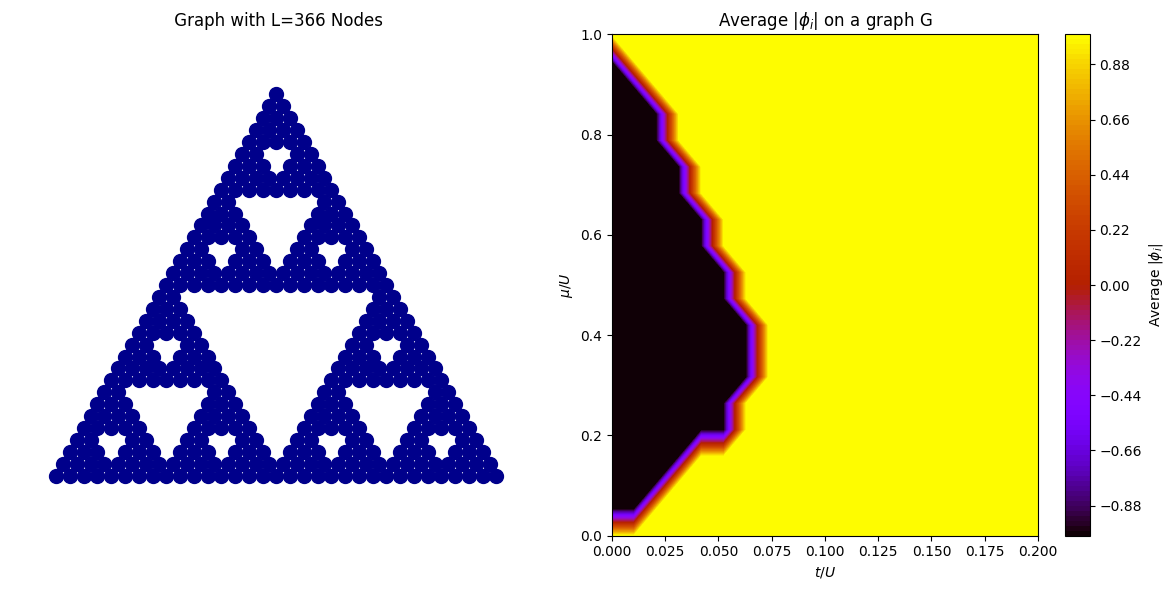

In [69]:
G,pos = sierpinski_triangle(5)

diag_ov=phaseDiagramDataParallel_overlap(G,point_number=20, parallel=True,max_iterations=1,parallel_gen_h=True,max_J = 0.2)
phaseDiagramPlotter(diag_ov,G,pos,binarize=True)

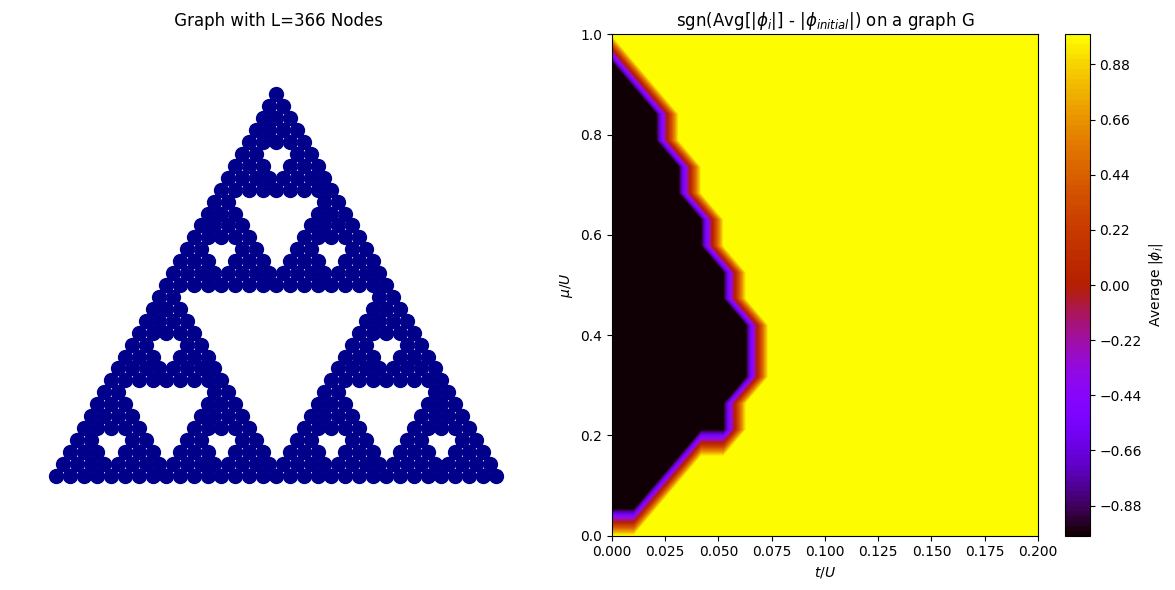

In [75]:

phaseDiagramPlotter(diag_ov,G,pos,binarize=True)

In [74]:
def phaseDiagramPlotter(data, G, pos, title="", filepath=None,binarize=False):
    t_over_U_values, mu_values, phi_avg_values = data 
    if binarize:
        phi_avg_values = np.sign(phi_avg_values - initial_phi)
    # Plotting
    t_over_U_mesh, mu_mesh = np.meshgrid(t_over_U_values, mu_values, indexing='ij')

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Left panel: Plot the graph
    ax = axs[0]
    # pos = nx.circular_layout(G)
    node_size = 100
    nx.draw(G, pos, with_labels=False, node_color='darkblue', edge_color='black', node_size=node_size, ax=ax)
    ax.set_title(f"{title} Graph with L={G.number_of_nodes()} Nodes")
    ax.axis('equal')

    # Right panel: Plot the phi density heatmap
    ax = axs[1]
    c = ax.contourf(t_over_U_mesh, mu_mesh / U, phi_avg_values, levels=100, cmap='gnuplot') #mistake in original code
    fig.colorbar(c, ax=ax, label=r'Average $|\phi_i|$')
    ax.set_ylabel(r'$\mu/U$')
    ax.set_xlabel(r'$t/U$')
    if not binarize:
        ax.set_title(f'Average $|\phi_i|$ on a graph G')
    else:
        ax.set_title('sgn(Avg[$|\phi_i|$] - $|\phi_{initial}|$) on a graph G')
    

    plt.tight_layout()
    if filepath != None:
        plt.savefig(filepath)
    plt.show()

In [10]:
#graph generating functions
def sierpinski_triangle(level, G=None, p1=(0, 0), p2=(1, 0), p3=(0.5, 0.866)):
    if G is None:
        G = nx.Graph()
    if level == 0:
        # Add the triangle edges
        G.add_edge(p1, p2)
        G.add_edge(p2, p3)
        G.add_edge(p3, p1)
    else:
        # Subdivide the triangle into 3 smaller triangles
        mid1 = ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)
        mid2 = ((p2[0] + p3[0]) / 2, (p2[1] + p3[1]) / 2)
        mid3 = ((p3[0] + p1[0]) / 2, (p3[1] + p1[1]) / 2)
        sierpinski_triangle(level - 1, G, p1, mid1, mid3)
        sierpinski_triangle(level - 1, G, mid1, p2, mid2)
        sierpinski_triangle(level - 1, G, mid3, mid2, p3)
    return G, {node: node for node in G.nodes}

def carpet_graph(n):
    #so far it has a unit length between sites
    def carpet(n):
        """Generate a Sierpiński carpet fractal matrix."""
        mat = np.array([[1]])
        for _ in range(n):
            mat = np.block([
                [mat, mat, mat],
                [mat, np.zeros_like(mat), mat],
                [mat, mat, mat],
            ])
        return mat
    """Generate the graph representation of a Sierpiński carpet."""
    fractal = carpet(n)
    rows, cols = fractal.shape
    G = nx.Graph()

    # Get all positions where the value is 1
    positions = np.argwhere(fractal == 1)
    pos_dict = {tuple(p): p for p in positions}

    # Add edges between adjacent positions
    offsets = [(1, 0), (0, 1)]  # Horizontal and vertical adjacency
    for x, y in positions:
        for dx, dy in offsets:
            neighbor = (x + dx, y + dy)
            if neighbor in pos_dict:
                G.add_edge((x, y), neighbor)

    return G, pos_dict

def tree_graph(r,h):
    G = nx.balanced_tree(r, h)
    #pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
    pos = nx.spring_layout(G)
    return G,pos

def cycle_graph(L):
    G = nx.cycle_graph(L)  # A ring graph
    pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
    return G,pos

def gridGraph(dims,periodic=False):
    G = nx.grid_graph(dim=dims, periodic=periodic)
    pos = {node: node for node in G.nodes}
    return G, pos

def triangleGraph(n0):
    """Create a triangular grid graph with n0+1 rows."""
    n = n0 + 1  # The number of rows
    G = nx.Graph()
    pos = {}
    
    # Create the list of nodes (tab) for each row
    tab = [list(range(sum(range(i)), sum(range(i + 1)))) for i in range(1, n + 1)]
    
    # Create the edges based on the nodes' connections
    edges = []
    for i in range(n - 1):
        for j in range(len(tab[i])):
            # Connect nodes within the same row
            if j < len(tab[i]) - 1:
                edges.append((tab[i][j], tab[i][j + 1]))
            # Connect nodes to the next row
            if j < len(tab[i + 1]):
                edges.append((tab[i][j], tab[i + 1][j]))
            if j + 1 < len(tab[i + 1]):
                edges.append((tab[i][j], tab[i + 1][j + 1]))
    
    # Connect the bottom row
    for j in range(len(tab[n - 1]) - 1):
        edges.append((tab[n - 1][j], tab[n - 1][j + 1]))  # Horizontal connections for the bottom row

    # Add nodes and edges to the graph
    G.add_nodes_from(sum(tab, []))
    G.add_edges_from(edges)

    # Assign positions for visualization
    for j in range(n):
        for i in range(len(tab[j])):
            pos[tab[j][i]] = (i - j / 2, -j * np.sqrt(3) / 2)
    
    return G, pos

import hypertiling as ht
def hypGraph(p,q,n,vertexCenter = False):
    #generate a graph from a hyperbolic tiling object
    #because the adjacency is between polygons, one needs to input p,q in reverse to get the desired graph
    #the same goes for a vertexCenter vs polygon center tiling
    if vertexCenter:
        T = ht.HyperbolicTiling(q, p, n)
        nbrs = T.get_nbrs_list()
    else:
        T = ht.HyperbolicTiling(q, p, n, center='vertex')
        nbrs = T.get_nbrs_list(method='RO')
    adMat = ht.operators.adjacency(nbrs) #sparse matrix
    G = nx.from_scipy_sparse_array(adMat)
    def tupFromComplex(z):
        return (z.real, z.imag)
    pos = {i : tupFromComplex(np.mean(T.get_vertices(i))) for i in range(len(nbrs))}
    return G, pos

#

In [ ]:
#compute above

In [13]:
for x,y in zip([1,2,3],[4,5,6]):
    print(x,y)

1 4
2 5
3 6


In [ ]:
G = nx.grid_graph(dim = (2,1), periodic=False)
basis_tup = gen_full_basis_faster(2,max_loc_flucs=1)
print(basis_tup[0])
for ml in gen_H_MF_frame_overlap(1,*basis_tup):
    print(ml[0])
    print('a')
    print(ml[1])
    print('b')
    print(ml[0].multiply(ml[1]))
    print('c')
    print(combine_H_MF_tup(*ml,[-10,10]))
    print('~~')

In [43]:
G = nx.grid_graph(dim = (5,5), periodic=False)
test = phaseDiagramDataParallel_overlap(G,point_number=3, parallel=False,max_iterations=2)

Starting calculation for 3 points of a size 25 sites


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Converged after 1 iterations
Converged after 1 iterations
Calculation completed in 3.70 seconds


Starting calculation for 20 points of a size 64 sites


Processing:   0%|          | 0/20 [00:00<?, ?it/s]

Calculation completed in 98.92 seconds


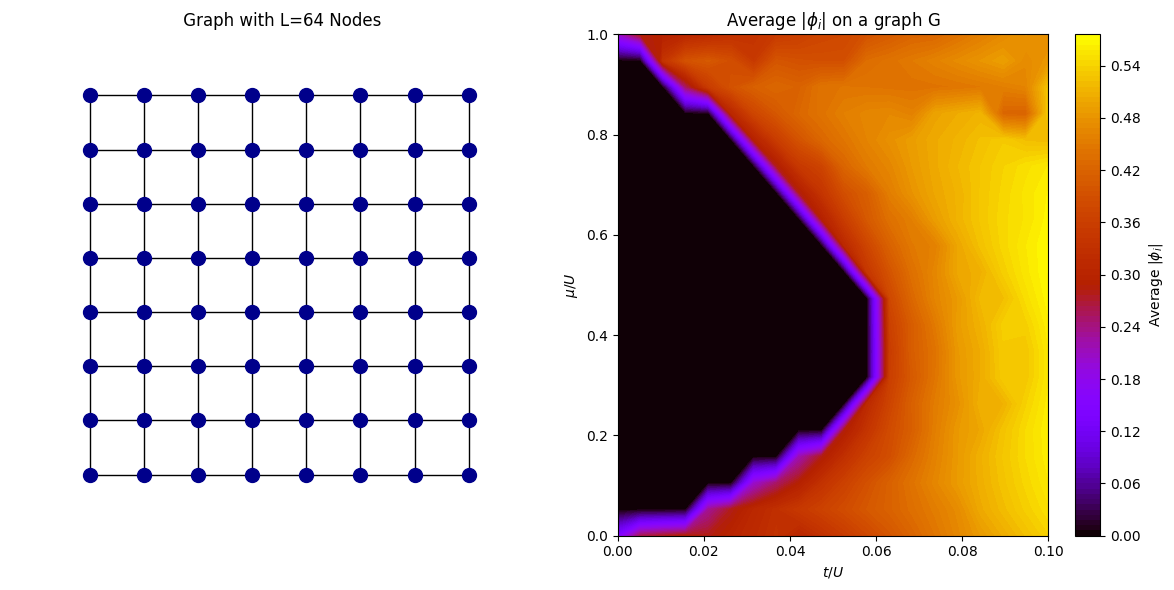

In [60]:
G,pos = gridGraph((8,8),periodic=False)

diag_ov=phaseDiagramDataParallel_overlap(G,point_number=20, parallel=True,max_iterations=50)
phaseDiagramPlotter(diag_ov,G,pos,binarize=False)

Starting calculation for 20 points of a size 64 sites


Generating hamiltonians:   0%|          | 0/64 [00:00<?, ?it/s]

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

Calculation completed in 428.53 seconds


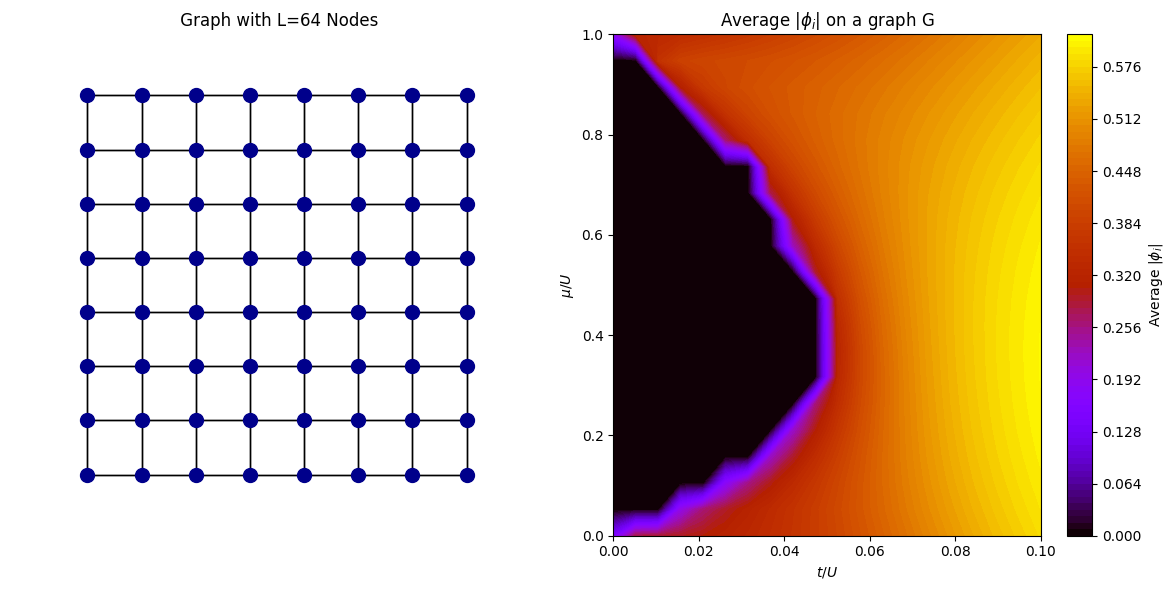

In [9]:
G,pos = gridGraph((8,8),periodic=True)

diag_ov=phaseDiagramDataParallel_overlap(G,point_number=20, parallel=True,max_iterations=50)
phaseDiagramPlotter(diag_ov,G,pos,binarize=False)

In [20]:
G,pos = gridGraph((6,6),periodic=False)

diag_ov_55=phaseDiagramDataParallel_overlap(G,point_number=20, parallel=True,max_iterations=50)
phaseDiagramPlotter(diag_ov_55,G,pos,binarize=False)

Starting calculation for 20 points of a size 36 sites


Generating hamiltonians:   0%|          | 0/36 [00:00<?, ?it/s]

KeyboardInterrupt: 

Starting calculation for 20 points of a size 36 sites


Processing:   0%|          | 0/20 [00:00<?, ?it/s]

Calculation completed in 53.89 seconds


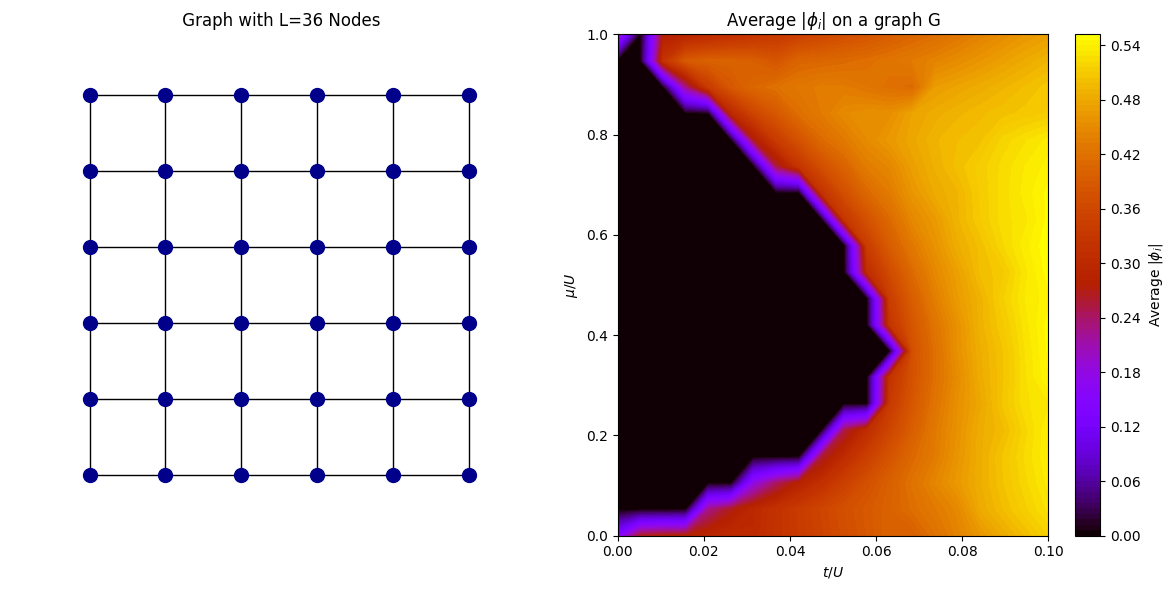

In [57]:
G,pos = gridGraph((6,6),periodic=False)

diag_ov_55=phaseDiagramDataParallel_overlap(G,point_number=20, parallel=True,max_iterations=50)
phaseDiagramPlotter(diag_ov_55,G,pos,binarize=False)

Starting calculation for 20 points of a size 36 sites


Processing:   0%|          | 0/20 [00:00<?, ?it/s]

Calculation completed in 85.85 seconds


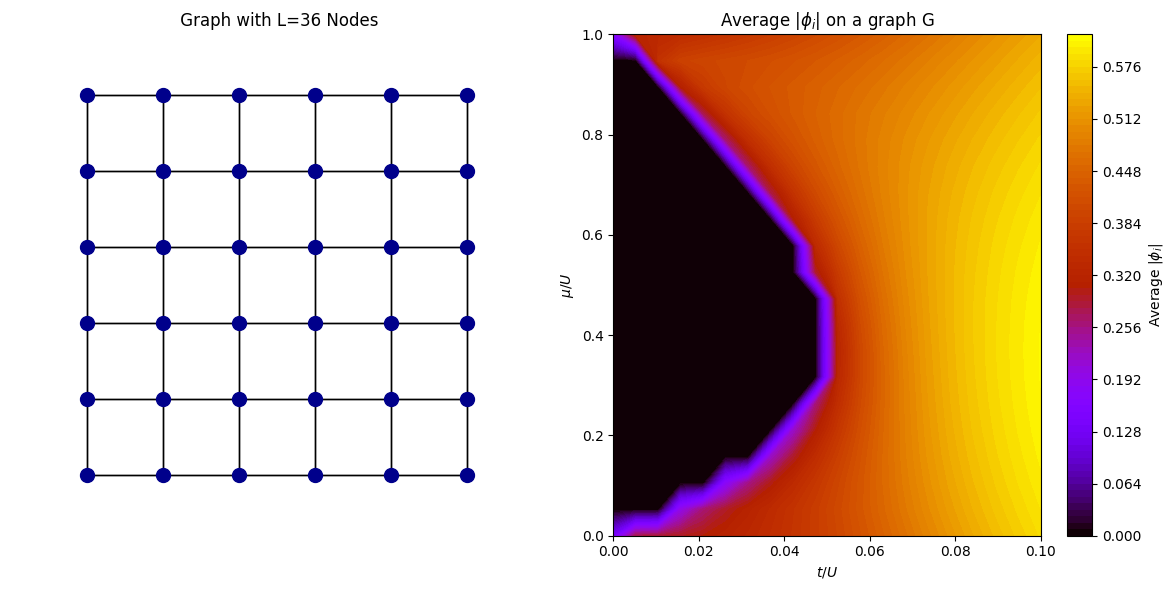

In [58]:
G,pos = gridGraph((6,6),periodic=True)

diag_ov_55=phaseDiagramDataParallel_overlap(G,point_number=20, parallel=True,max_iterations=50)
phaseDiagramPlotter(diag_ov_55,G,pos,binarize=False)

Starting calculation for 20 points of a size 42 sites


Generating hamiltonians:   0%|          | 0/42 [00:00<?, ?it/s]

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

Calculation completed in 407.51 seconds


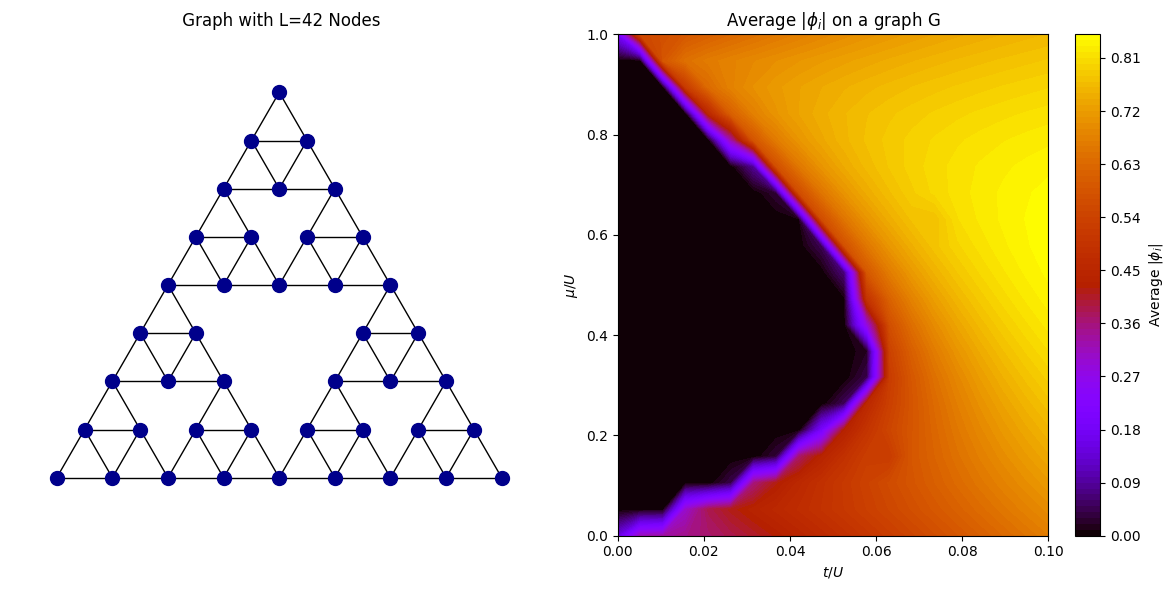

In [17]:
G,pos = sierpinski_triangle(3)

diag_ov=phaseDiagramDataParallel_overlap(G,point_number=20, parallel=True,max_iterations=10)
phaseDiagramPlotter(diag_ov,G,pos,binarize=False)

Starting calculation for 40 points of a size 42 sites


Generating hamiltonians:   0%|          | 0/42 [00:00<?, ?it/s]

Processing:   0%|          | 0/1600 [00:00<?, ?it/s]

Calculation completed in 1217.10 seconds


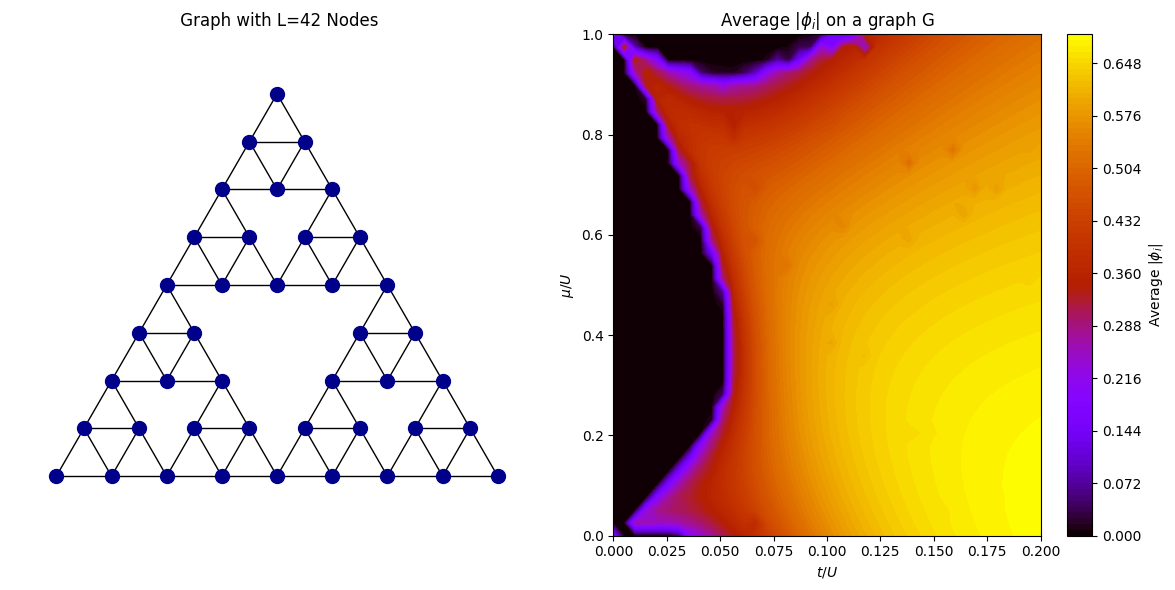

In [13]:
G,pos = sierpinski_triangle(3)

diag_ov=phaseDiagramDataParallel_overlap(G,point_number=40, parallel=True,max_iterations=20,max_J=0.2)
phaseDiagramPlotter(diag_ov,G,pos,binarize=False)

Starting calculation for 40 points of a size 42 sites


Processing:   0%|          | 0/40 [00:00<?, ?it/s]

Calculation completed in 334.91 seconds


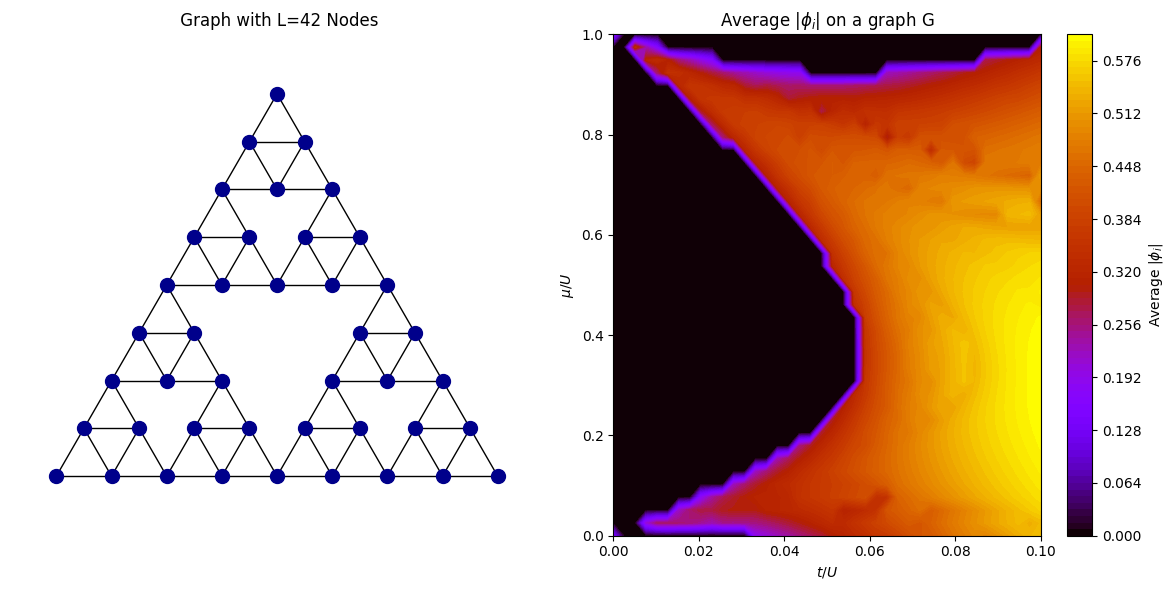

In [65]:
G,pos = sierpinski_triangle(3)

diag_ov=phaseDiagramDataParallel_overlap(G,point_number=40, parallel=True,max_iterations=70)
phaseDiagramPlotter(diag_ov,G,pos,binarize=False)

Starting calculation for 40 points of a size 49 sites


Processing:   0%|          | 0/40 [00:00<?, ?it/s]

Calculation completed in 275.57 seconds


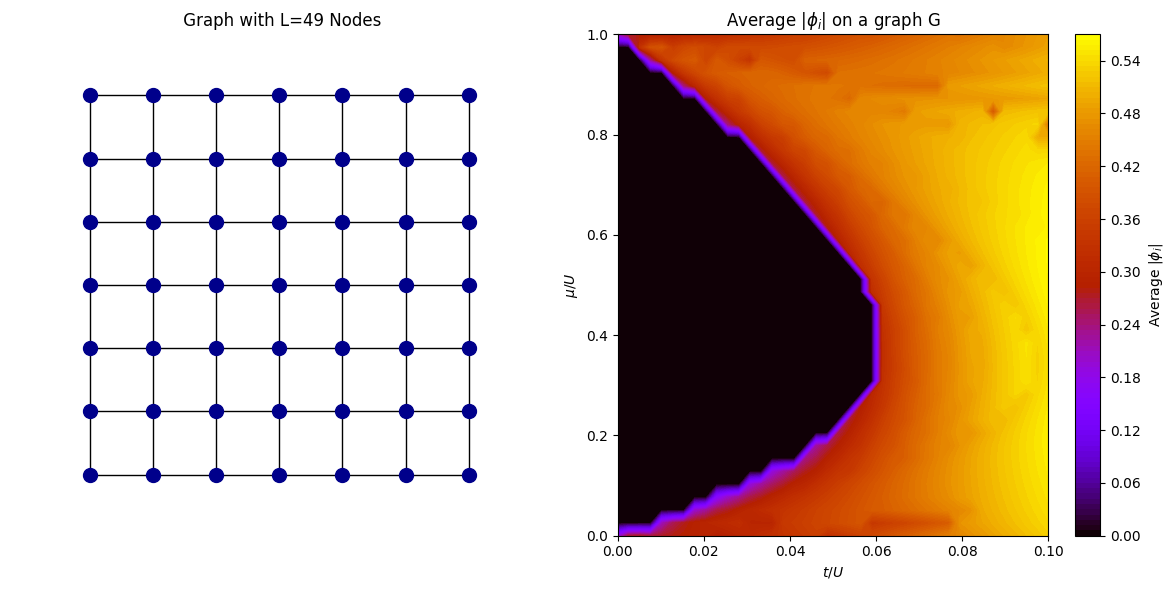

In [64]:
G,pos = gridGraph((7,7),periodic=False)

diag_ov=phaseDiagramDataParallel_overlap(G,point_number=40, parallel=True,max_iterations=70)
phaseDiagramPlotter(diag_ov,G,pos,binarize=False)

Starting calculation for 40 points of a size 49 sites


Generating hamiltonians:   0%|          | 0/49 [00:00<?, ?it/s]

Processing:   0%|          | 0/1600 [00:00<?, ?it/s]

Calculation completed in 432.81 seconds


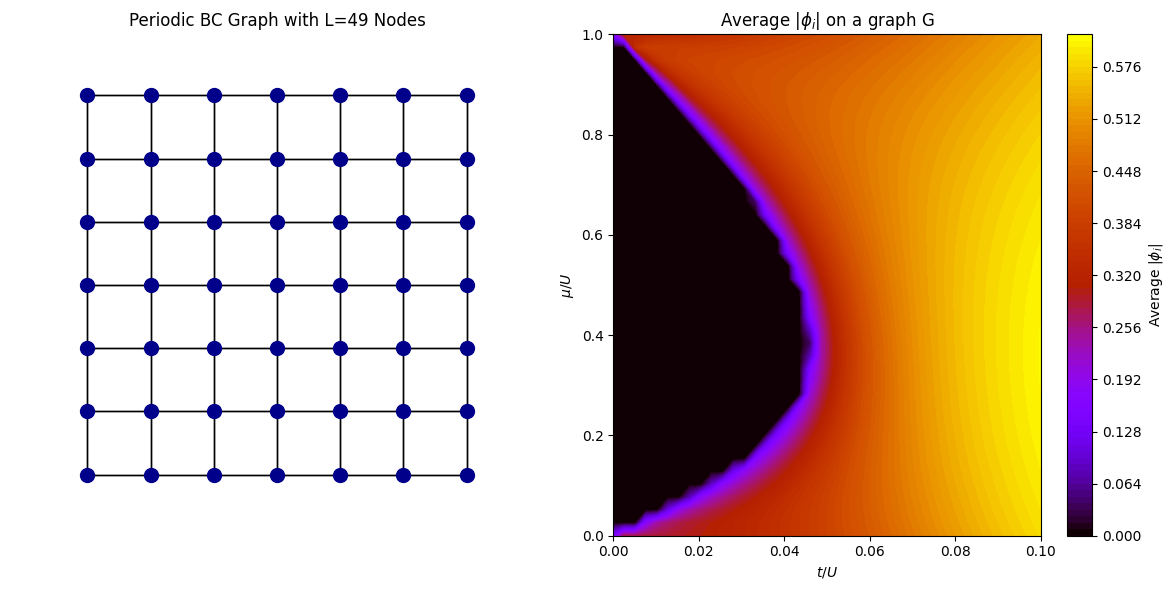

In [8]:
G,pos = gridGraph((7,7),periodic=True)

diag_ov=phaseDiagramDataParallel_overlap(G,point_number=40, parallel=True,max_iterations=70)
phaseDiagramPlotter(diag_ov,G,pos,binarize=False,title='Periodic BC')

In [18]:
G,pos = sierpinski_triangle(2)

neighbours_range = 2#L  # Cluster neighbor range
diag_ov=phaseDiagramDataParallel_overlap(G,point_number=10, parallel=True,max_iterations=30)

neighbours_range = 1#L  # Cluster neighbor range

phaseDiagramPlotter(diag_ov,G,pos,binarize=False)

Starting calculation for 10 points of a size 15 sites


Generating hamiltonians:   0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

Starting calculation for 60 points of a size 123 sites


Generating hamiltonians:   0%|          | 0/123 [00:00<?, ?it/s]

Processing:   0%|          | 0/60 [00:00<?, ?it/s]

Calculation completed in 2527.55 seconds


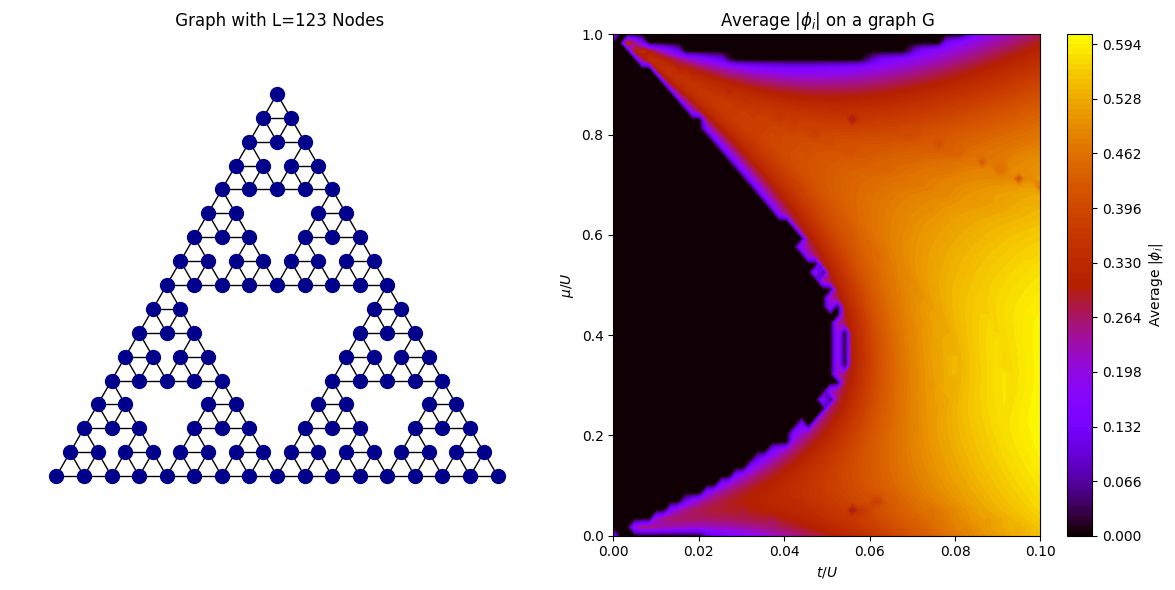

In [17]:
G,pos = sierpinski_triangle(4)

diag_ov_largeS=phaseDiagramDataParallel_overlap(G,point_number=60, parallel=True,max_iterations=70)
phaseDiagramPlotter(diag_ov_largeS,G,pos,binarize=False)

Starting calculation for 30 points of a size 42 sites


Generating hamiltonians:   0%|          | 0/42 [00:00<?, ?it/s]

Processing:   0%|          | 0/30 [00:00<?, ?it/s]

Calculation completed in 270.85 seconds


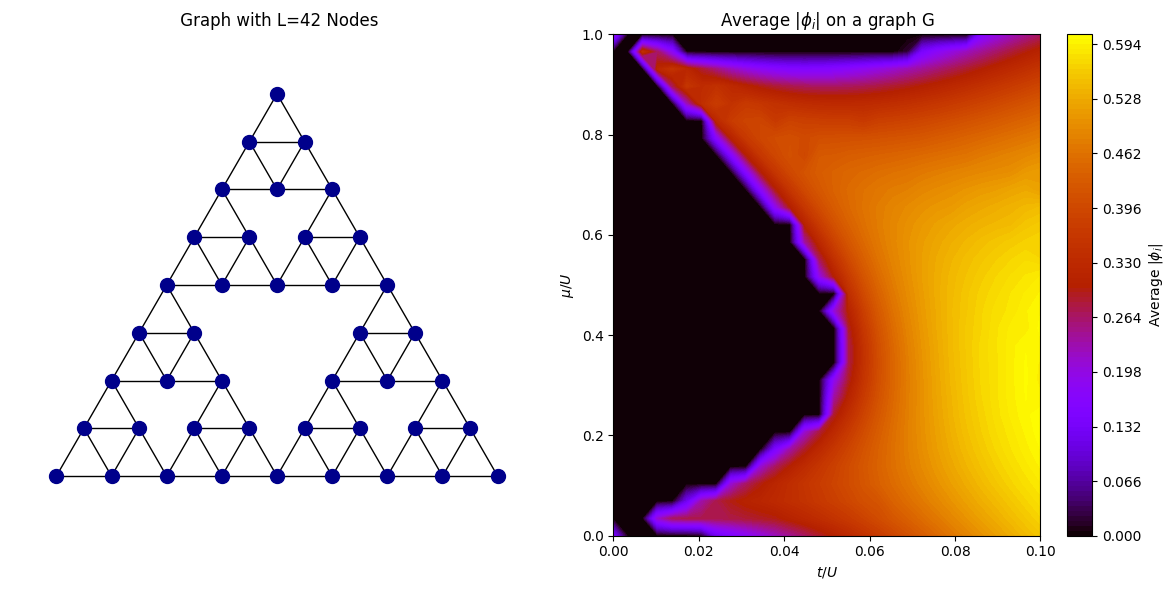

In [9]:
G,pos = sierpinski_triangle(3)

neighbours_range = 1#L  # Cluster neighbor range
diag_ov=phaseDiagramDataParallel_overlap(G,point_number=30, parallel=True,max_iterations=70)

neighbours_range = 1#L  # Cluster neighbor range

phaseDiagramPlotter(diag_ov,G,pos,binarize=False)

Starting calculation for 40 points of a size 42 sites


Generating hamiltonians:   0%|          | 0/42 [00:00<?, ?it/s]

Processing:   0%|          | 0/1600 [00:00<?, ?it/s]

Calculation completed in 442.23 seconds


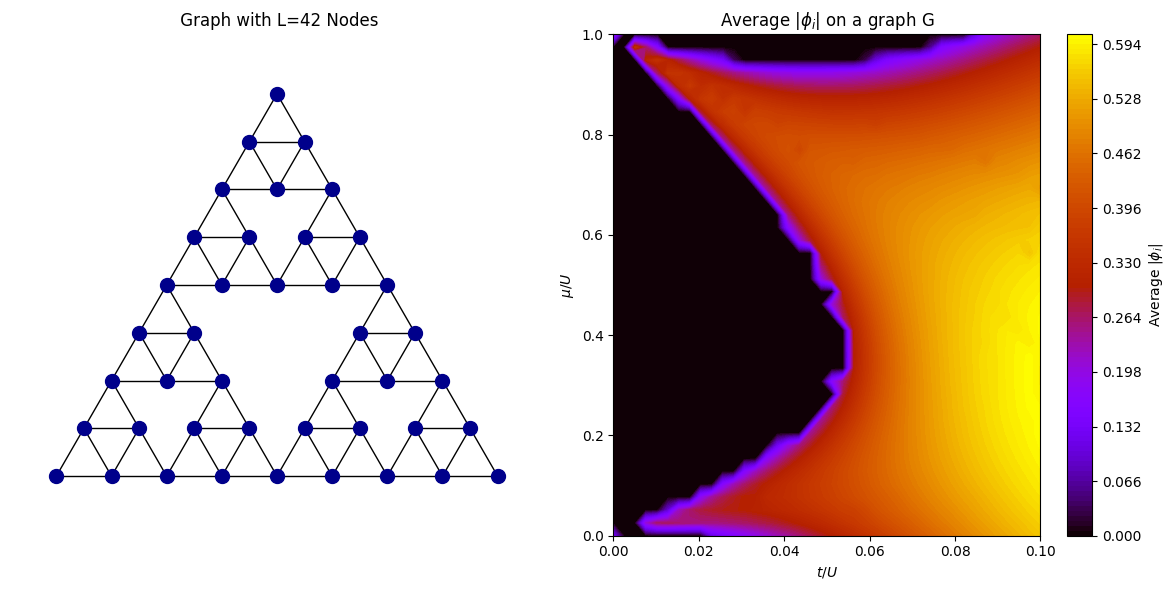

In [16]:
G,pos = sierpinski_triangle(3)

neighbours_range = 1#L  # Cluster neighbor range
diag_ov=phaseDiagramDataParallel_overlap(G,point_number=40, parallel=True,max_iterations=70)

neighbours_range = 1#L  # Cluster neighbor range

phaseDiagramPlotter(diag_ov,G,pos,binarize=False)

Starting calculation for 30 points of a size 42 sites


Generating hamiltonians:   0%|          | 0/42 [00:00<?, ?it/s]

Processing:   0%|          | 0/900 [00:00<?, ?it/s]

Calculation completed in 17089.93 seconds


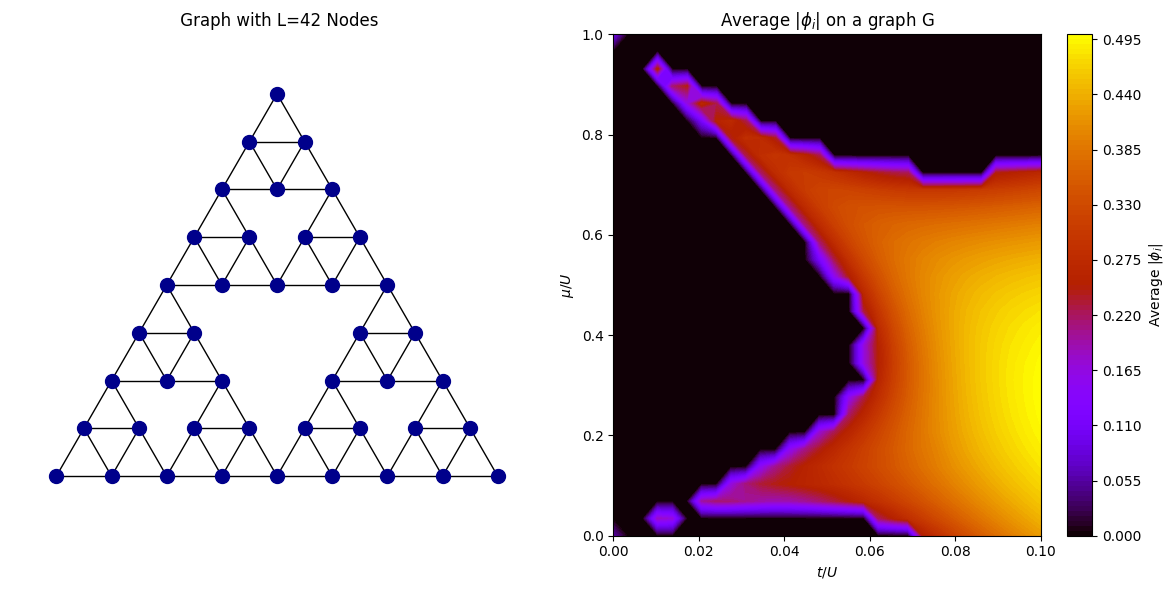

In [8]:
G,pos = sierpinski_triangle(3)

neighbours_range = 2#L  # Cluster neighbor range
diag_ov=phaseDiagramDataParallel_overlap(G,point_number=30, parallel=True,max_iterations=50)

neighbours_range = 1#L  # Cluster neighbor range

phaseDiagramPlotter(diag_ov,G,pos,binarize=False)

In [46]:
G = nx.grid_graph(dim = (3,3), periodic=False)
adj_mat = nx.adjacency_matrix(G)
target_node = adj_mat.shape[0]//2 #assuming it is in the middle
def testFnc(G,target_node,niu_expected_edges,crit_phi = initial_phi,max_J=0.1,xtol=1e-5,mu_min=0,mu_max=1,
                      point_number=100, parallel=True, max_global_flucs=5):
    print(f'Starting calculation for {point_number} points of a size {G.number_of_nodes()} sites')
    start_time = time.time()

    eps = 1e-4
    mu_values = np.linspace(mu_min+eps, mu_max-eps, point_number)

    adj_mat = nx.adjacency_matrix(G)
    neib_num = np.sum(adj_mat.todense(),axis=0)
    niu = niu_expected_edges - neib_num
    print(niu)
    #Generate the basis
    st = time.time()

    M = adj_mat.shape[0]
    basis_tup = gen_full_basis_faster(M, max_global_flucs=max_global_flucs)
    print(f"Basis of size {len(basis_tup[0])} generated in {time.time() - st:.4f} s")

    vList = basis_tup[0]

    #Generate the Hamiltonian components with parameters J, mu, phi equal to 1 (U in h_int has the global U value)
    st = time.time()

    h_kin_o_J =  gen_H_kin_over_J(adj_mat,*basis_tup)
    h_int = gen_H_int(vList)
    h_chem_o_mu = gen_H_chem_over_mu(vList)
    H_MF_tup = gen_H_MF_homogenous(1,niu,1,*basis_tup,return_separately=True)

    H_tuple_mu1_J1 = h_kin_o_J, h_int, h_chem_o_mu, H_MF_tup

    print(f"H of size {h_int.shape[0]} generated in {time.time() - st:.4f} s")
    J = 0.02
    mu = 0.05
    H_inside = J*h_kin_o_J + h_int + mu*h_chem_o_mu
    phi = initial_phi
    H_MF_phi1_base, H_MF_phi1_conj = H_MF_tup
    H_MF = J*phi*H_MF_phi1_base + J*np.conj(phi)*H_MF_phi1_conj
    H_C = H_inside + H_MF
    st = time.time()
    test = eigsh(H_C,k=10,which='SA')
    print(f"H of size {H_C.shape[0]} solved in {time.time() - st:.4f} s")
    
    print(f"Energy = {test[0]}") 

    ground_state_list = [test[1][:, i] for i in range(10)]
    ground_state_list = [ground_state/np.linalg.norm(ground_state) for ground_state in ground_state_list]
    
    #. phi {phi_at_site_t(*basis_tup, test[0][:, 0], target_node)}")
    st = time.time()
    
    test2 = [phi_at_site_t(*basis_tup, ground_state, target_node) for ground_state in ground_state_list]
    #test2 = homogenous_cluster_calculate_phi_H_tuple(mu, J, H_tuple_mu1_J1, target_node, *basis_tup)
    print(f"Phi calculated in  {time.time() - st:.4f} s, phi = {test2}")
testFnc(G,3,4)

Starting calculation for 100 points of a size 9 sites
[2 1 2 1 0 1 2 1 2]
Basis of size 6211 generated in 0.0670 s
H of size 6211 generated in 2.9040 s
H of size 6211 solved in 0.1070 s
Energy = [-0.47520238 -0.46932388 -0.44292238 -0.44292238 -0.41449377 -0.41208023
 -0.41205782 -0.38677898 -0.38677898 -0.36169313]
Phi calculated in  0.5370 s, phi = [5.380156561184092e-06, -5.321331495408644e-06, 5.457622350641655e-08, 4.0483389608289764e-08, 5.3749332054292695e-08, 4.240145256961279e-08, 7.553633414273727e-08, 5.423752582069801e-08, 4.2614186467249764e-08, 7.608961607263797e-08]


Starting calculation for 100 points of a size 1 sites
Basis of size 3 generated in 0.0000 s
H of size 3 generated in 0.0000 s
H of size 3 solved in 0.0000 s
1 0.00 seconds
2 0.00 seconds
Energy = -0.9900000000012865
2.5 0.00 seconds
3 0.00 seconds
Phi calculated in  0.0010 s, phi = 1.6080808080866776e-05


Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Calculation completed in 6.11 seconds


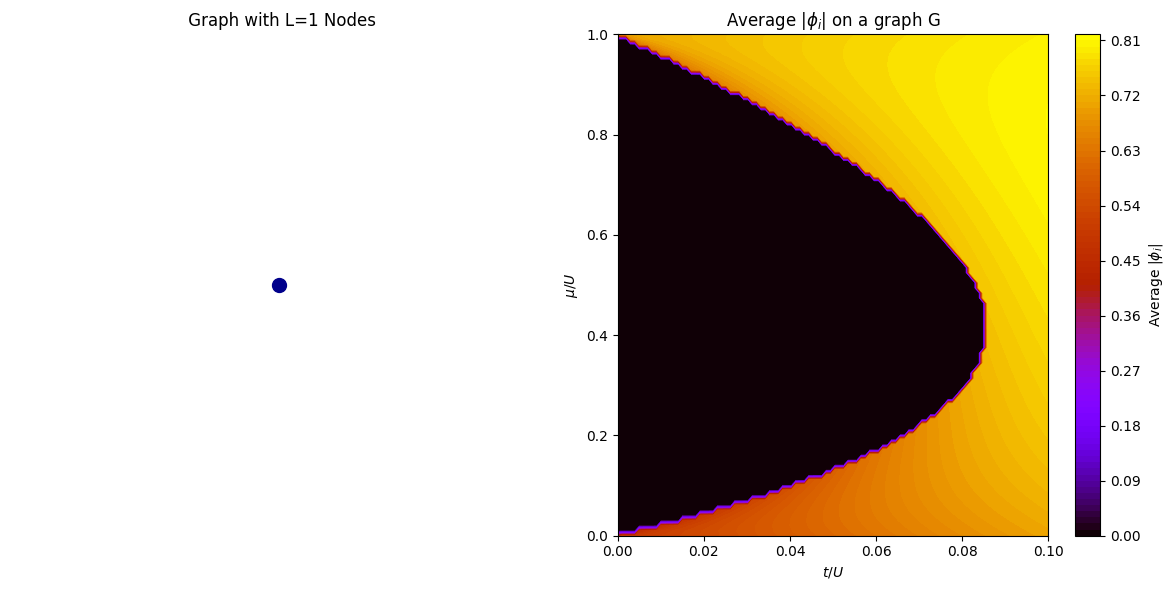

In [55]:
G,pos = gridGraph((1,1))

diag11=phaseDiagramDataParallel_H_tuple(G,0,4,point_number=100,max_iterations=200)
phaseDiagramPlotter(diag11,G,pos)

Starting calculation for 100 points of a size 2 sites
Basis of size 9 generated in 0.0000 s
H of size 9 generated in 0.0020 s
H of size 9 solved in 0.0000 s
1 0.00 seconds
2 0.00 seconds
Energy = -2.0105880657743653
2.5 0.00 seconds
3 0.00 seconds
Phi calculated in  0.0010 s, phi = 4.329236978641406e-06


Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Calculation completed in 8.33 seconds


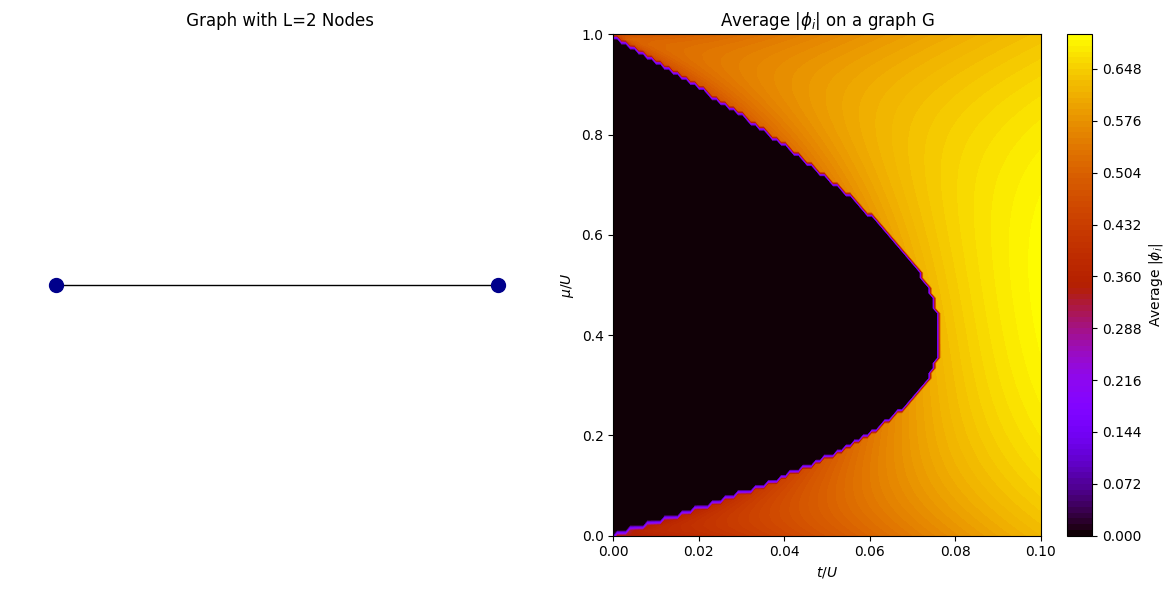

In [56]:
G,pos = gridGraph((1,2))

diag12=phaseDiagramDataParallel_H_tuple(G,0,4,point_number=100,max_iterations=200)
phaseDiagramPlotter(diag12,G,pos)

Starting calculation for 60 points of a size 9 sites
Basis of size 10354 generated in 0.1733 s
H of size 10354 generated in 5.7222 s
H of size 10354 solved in 0.1342 s
1 0.00 seconds
2 0.13 seconds
Energy = -9.162403271589213
2.5 0.13 seconds
3 0.23 seconds
Phi calculated in  0.2320 s, phi = 0.00023576742288640272


Processing:   0%|          | 0/3600 [00:00<?, ?it/s]

Calculation completed in 191.71 seconds


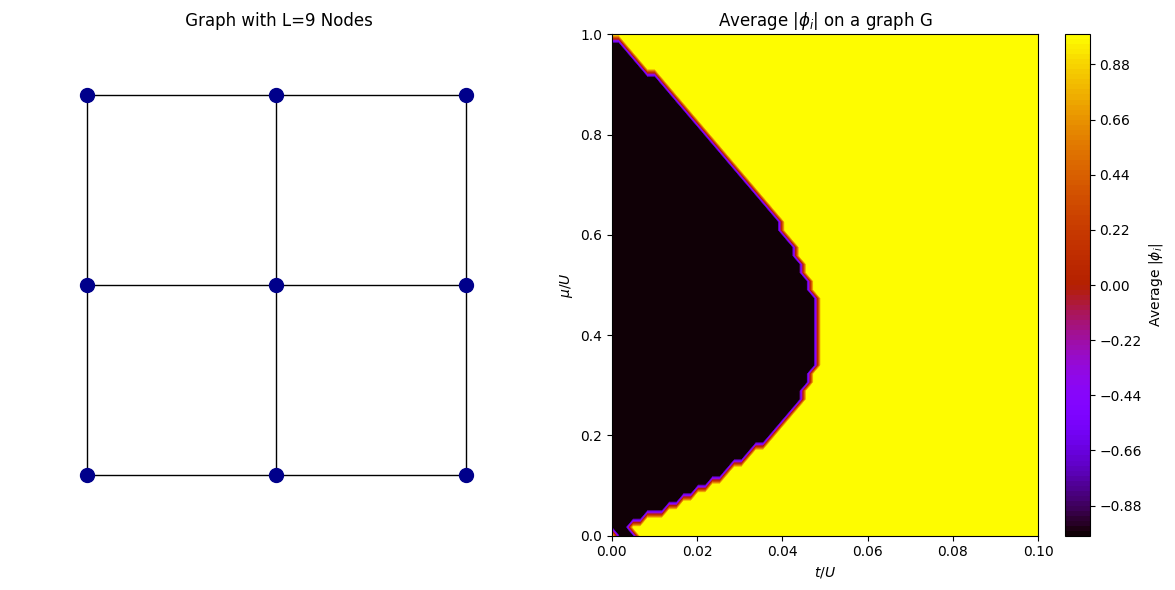

In [27]:
initial_phi=1e-4
tolerance = 1e-6
G,pos = gridGraph((3,3))

diag22=phaseDiagramDataParallel_H_tuple(G,0,4,point_number=60,max_iterations=1,max_global_flucs=5,max_loc_flucs=2)
phaseDiagramPlotter(diag22,G,pos,binarize=True)

Starting calculation for 100 points of a size 9 sites
Basis of size 6211 generated in 0.0660 s
H of size 6211 generated in 2.7753 s
H of size 6211 solved in 0.0365 s
1 0.00 seconds
2 0.03 seconds
Energy = -9.033452711869074
2.5 0.03 seconds
3 0.10 seconds
Phi calculated in  0.0972 s, phi = 4.23074128963435e-07


Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Calculation completed in 130.31 seconds


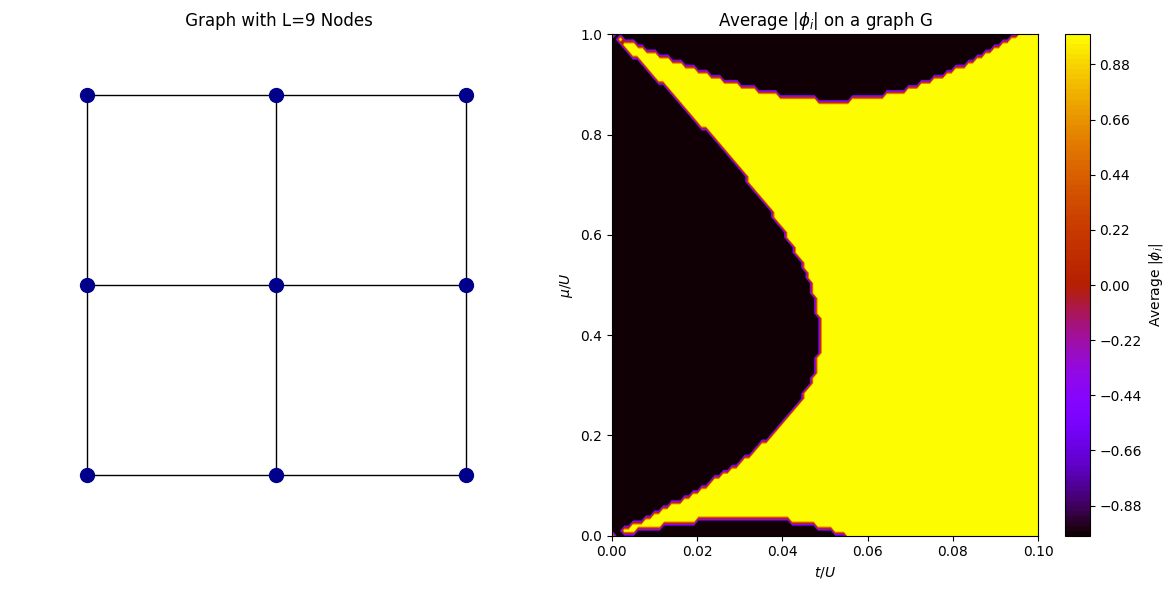

In [73]:
G,pos = gridGraph((3,3))

diag22=phaseDiagramDataParallel_H_tuple(G,0,4,point_number=100,max_iterations=1,max_global_flucs=5,max_loc_flucs=2)
phaseDiagramPlotter(diag22,G,pos,binarize=True)

Starting calculation for 100 points of a size 4 sites
Basis of size 91 generated in 0.0040 s
H of size 91 generated in 0.0560 s
H of size 91 solved in 0.0040 s
1 0.00 seconds
2 0.00 seconds
Energy = -4.03594353857457
2.5 0.00 seconds
3 0.01 seconds
Phi calculated in  0.0060 s, phi = 0.00012820304935907165


Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Calculation completed in 162.40 seconds


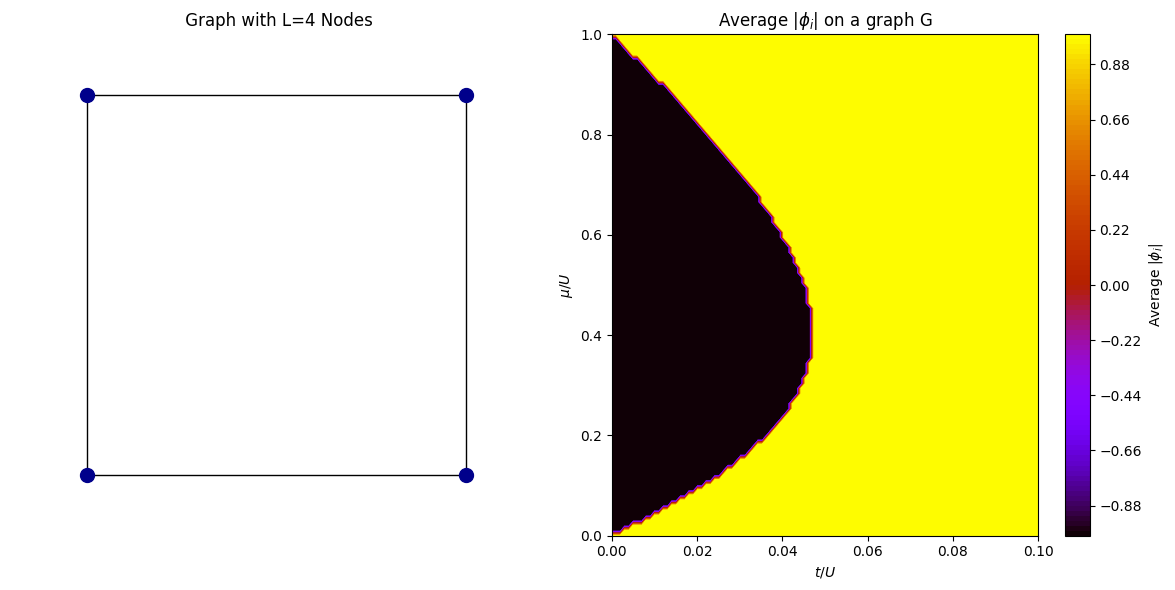

In [11]:
G,pos = gridGraph((2,2))

diag22=phaseDiagramDataParallel_H_tuple(G,0,4,point_number=100,max_iterations=200,max_global_flucs=5,max_loc_flucs=2)
phaseDiagramPlotter(diag22,G,pos,binarize=True)

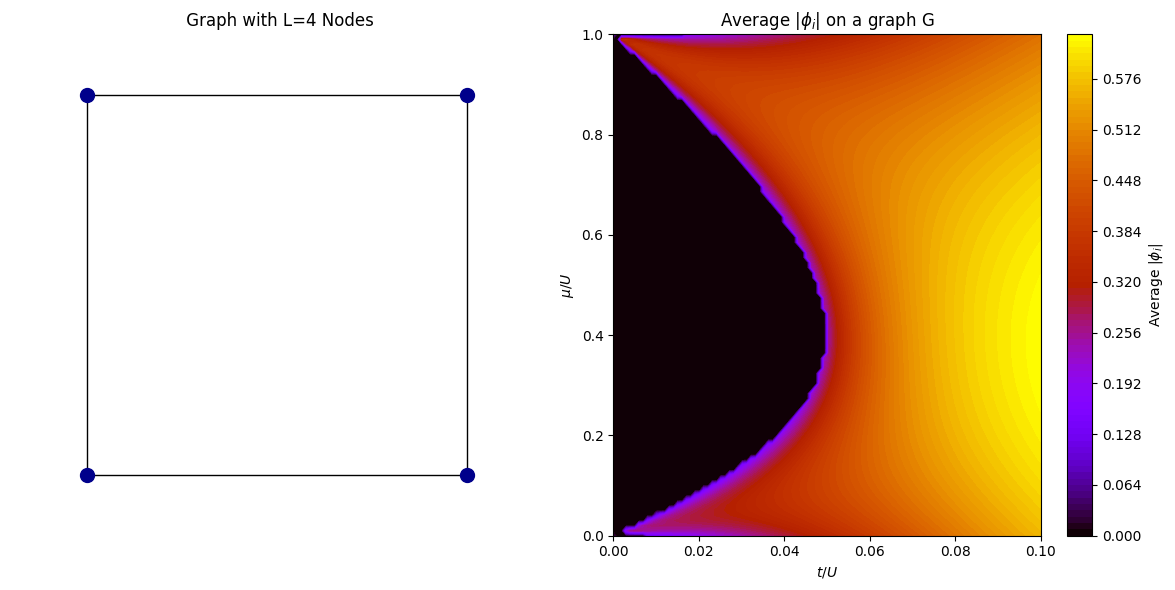

In [12]:
phaseDiagramPlotter(diag22,G,pos)

Starting calculation for 100 points of a size 4 sites
Basis of size 91 generated in 0.0030 s
H of size 91 generated in 0.0611 s
H of size 91 solved in 0.0020 s
1 0.00 seconds
2 0.00 seconds
Energy = -4.035943536523527
2.5 0.00 seconds
3 0.01 seconds
Phi calculated in  0.0070 s, phi = 1.2820305676469322e-06


Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Calculation completed in 18.34 seconds


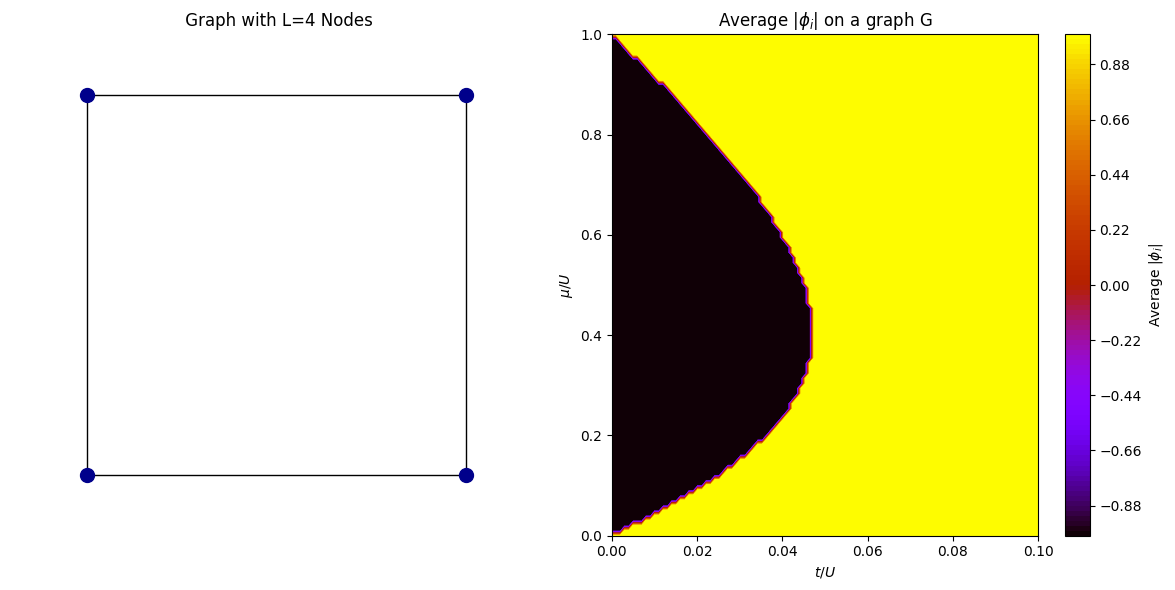

In [16]:

tolerance = 1e-9 # Convergence tolerance
initial_phi = 1e-6

G,pos = gridGraph((2,2))

diag22=phaseDiagramDataParallel_H_tuple(G,0,4,point_number=100,max_iterations=2,max_global_flucs=5,max_loc_flucs=2)
phaseDiagramPlotter(diag22,G,pos,binarize=True)

Starting calculation for 100 points of a size 4 sites
Basis of size 91 generated in 0.0000 s
H of size 91 generated in 0.0182 s
H of size 91 solved in 0.0000 s
1 0.00 seconds
2 0.00 seconds
Energy = -4.035943536523524
2.5 0.00 seconds
3 0.00 seconds
Phi calculated in  0.0020 s, phi = 1.2820305769245165e-06


Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Calculation completed in 30.19 seconds


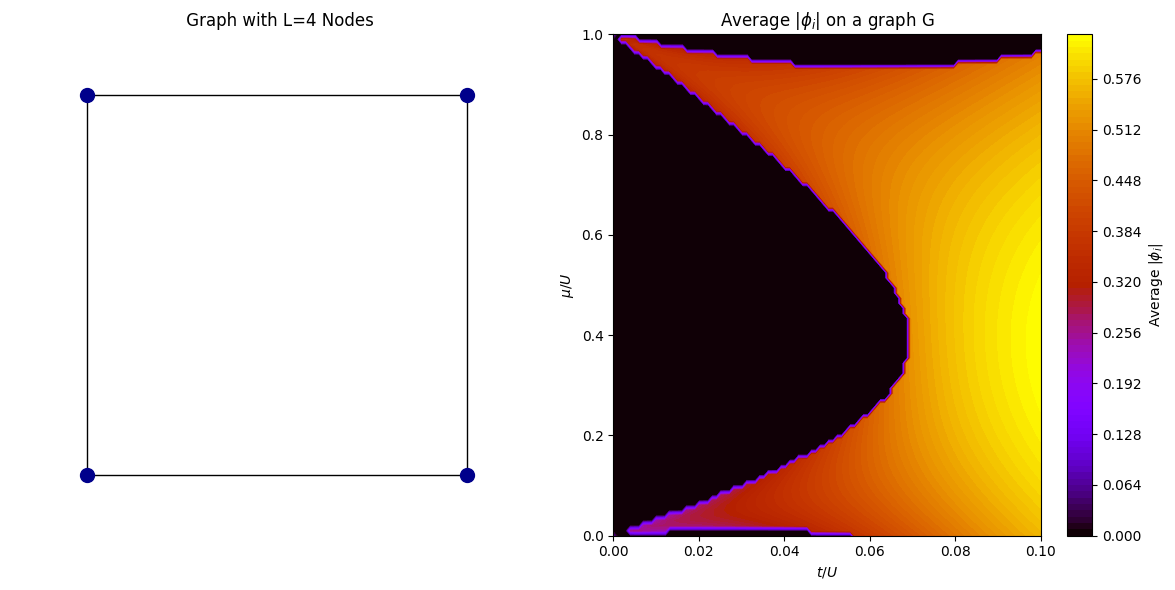

In [66]:
G,pos = gridGraph((2,2))

diag22=phaseDiagramDataParallel_H_tuple(G,0,4,point_number=100,max_iterations=200,max_global_flucs=5,max_loc_flucs=2)
phaseDiagramPlotter(diag22,G,pos)

Starting calculation for 50 points of a size 6 sites
Basis of size 703 generated in 0.0090 s
H of size 703 generated in 0.1943 s
H of size 703 solved in 0.0148 s
1 0.00 seconds
2 0.01 seconds
Energy = -6.037914737582174
2.5 0.01 seconds
3 0.02 seconds
Phi calculated in  0.0207 s, phi = 7.400496115934729e-07


Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Calculation completed in 30.22 seconds


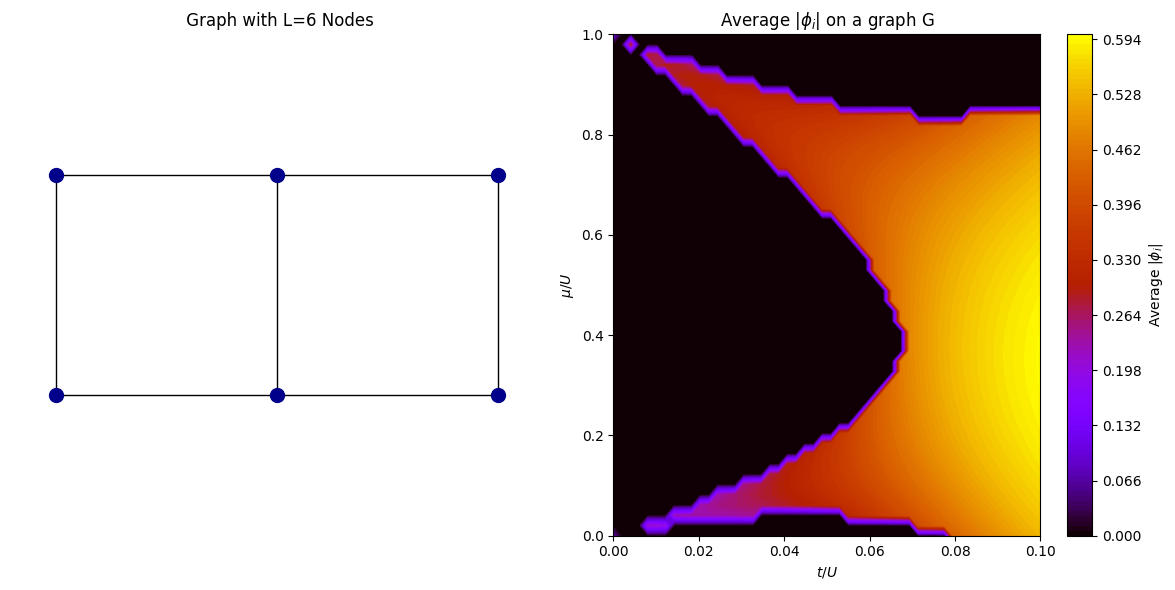

In [58]:
G,pos = gridGraph((2,3))

diag23=phaseDiagramDataParallel_H_tuple(G,1,4,point_number=50,max_iterations=200)
phaseDiagramPlotter(diag23,G,pos)

Starting calculation for 50 points of a size 9 sites
Basis of size 6211 generated in 0.0722 s
H of size 6211 generated in 2.7273 s
H of size 6211 solved in 0.0384 s
1 0.00 seconds
2 0.03 seconds
Energy = -9.033452711869081
2.5 0.03 seconds
3 0.08 seconds
Phi calculated in  0.0824 s, phi = 7.430877630695072e-07


Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Calculation completed in 206.72 seconds


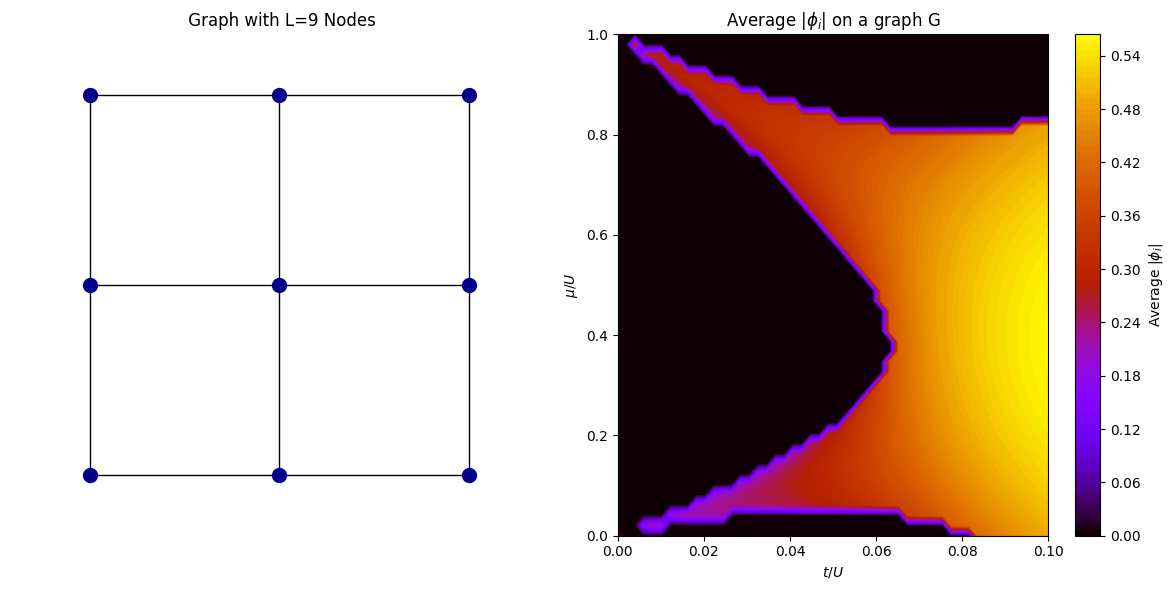

In [67]:
G,pos = gridGraph((3,3))

diag33=phaseDiagramDataParallel_H_tuple(G,(3*3)//2,4,point_number=50,max_iterations=100)
phaseDiagramPlotter(diag33,G,pos)

Starting calculation for 30 points of a size 12 sites
Basis of size 28999 generated in 0.3702 s
H of size 28999 generated in 15.9780 s
H of size 28999 solved in 0.1054 s
1 0.00 seconds
2 0.10 seconds
Energy = -12.020297629886404
2.5 0.10 seconds
3 0.33 seconds
Phi calculated in  0.3400 s, phi = 5.601696788182765e-07


Processing:   0%|          | 0/30 [00:00<?, ?it/s]

Calculation completed in 549.49 seconds


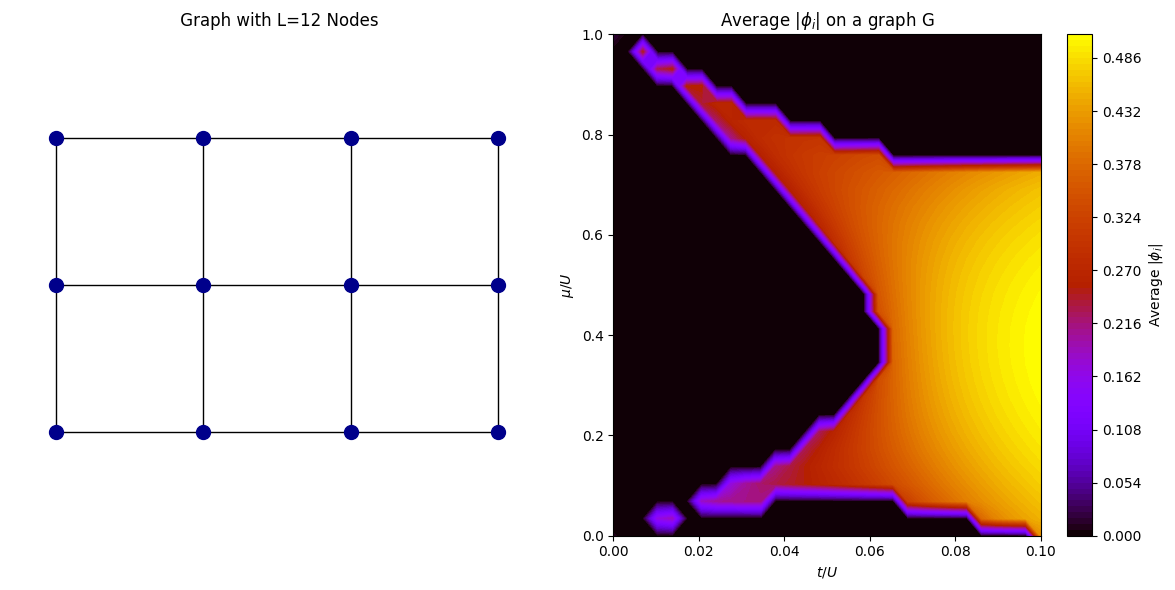

In [69]:
G,pos = gridGraph((3,4))

diag34=phaseDiagramDataParallel_H_tuple(G,4,4,point_number=30,max_iterations=20)
phaseDiagramPlotter(diag34,G,pos)

Starting calculation for 50 points of a size 12 sites
Basis of size 28999 generated in 0.4547 s
H of size 28999 generated in 16.3526 s
H of size 28999 solved in 0.1152 s
1 0.00 seconds
2 0.10 seconds
Energy = -12.020297629886418
2.5 0.10 seconds
3 0.33 seconds
Phi calculated in  0.3366 s, phi = 2.9518482004769324e-07


Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Calculation completed in 296.28 seconds


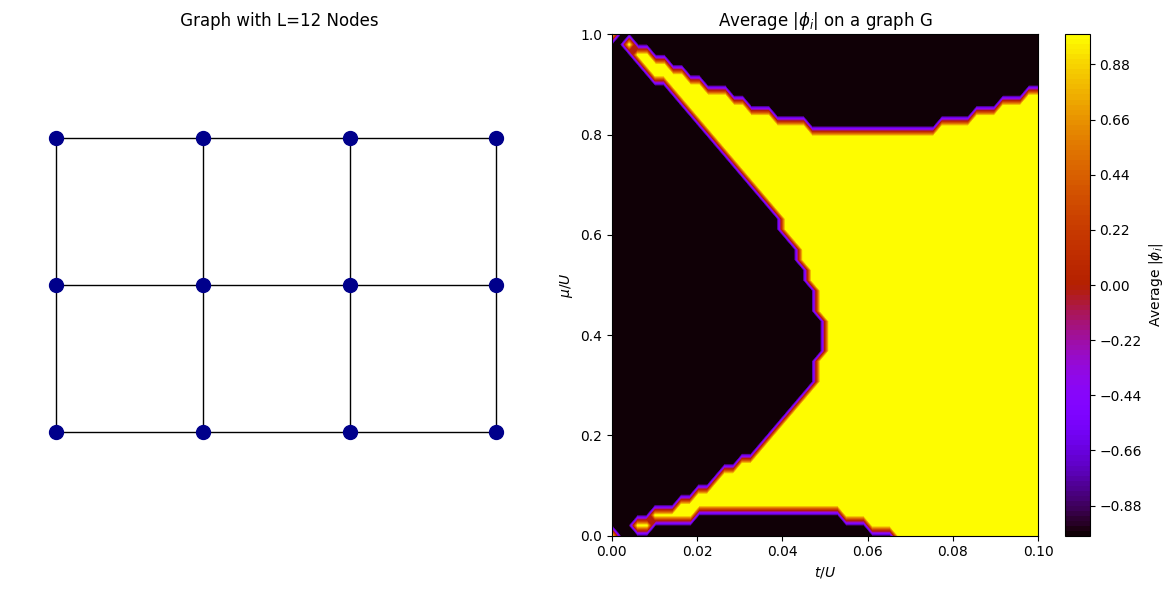

In [75]:
G,pos = gridGraph((3,4))

diag=phaseDiagramDataParallel_H_tuple(G,0,4,point_number=50,max_iterations=1)
phaseDiagramPlotter(diag,G,pos,binarize=True)

Starting calculation for 50 points of a size 15 sites
Basis of size 94636 generated in 1.4917 s
H of size 94636 generated in 58.7606 s
H of size 94636 solved in 0.3449 s
1 0.01 seconds
2 0.34 seconds
Energy = -15.04224589125286
2.5 0.34 seconds
3 1.11 seconds
Phi calculated in  1.1346 s, phi = 7.991469921498108e-08


Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Calculation completed in 911.92 seconds


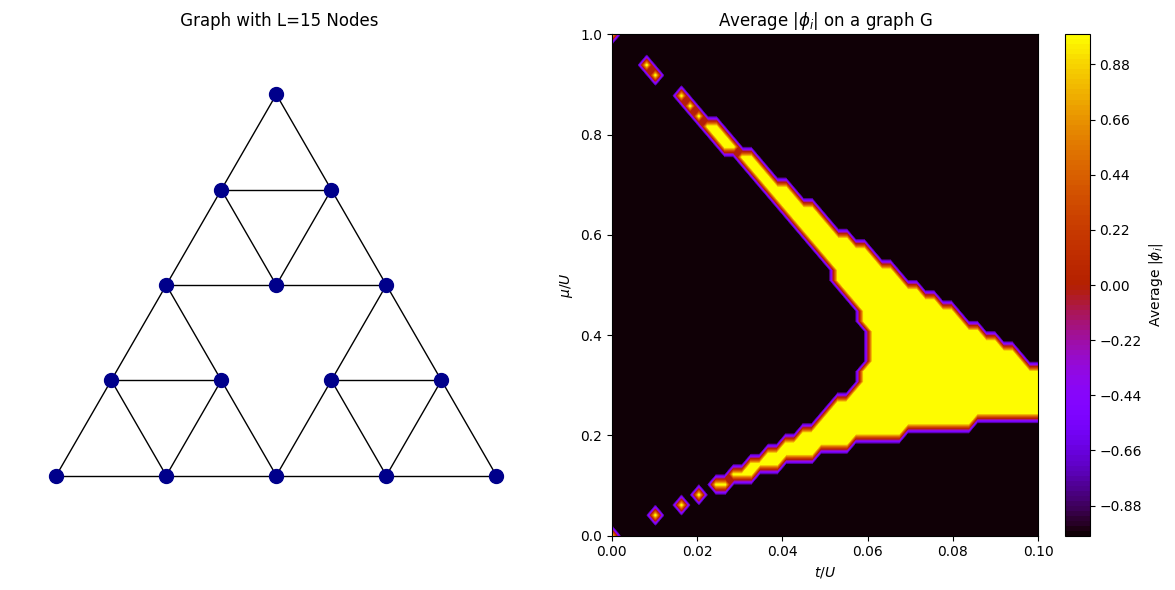

In [76]:
G,pos = sierpinski_triangle(2)

diagS2=phaseDiagramDataParallel_H_tuple(G,0,4,point_number=50,max_iterations=1)
phaseDiagramPlotter(diagS2,G,pos,binarize=True)

Starting calculation for 70 points of a size 15 sites
Basis of size 94636 generated in 1.5556 s
H of size 94636 generated in 56.2846 s
H of size 94636 solved in 0.2921 s
1 0.01 seconds
2 0.31 seconds
Energy = -15.04224589125286
2.5 0.31 seconds
3 1.07 seconds
Phi calculated in  1.0928 s, phi = 8.462405375466628e-08


Processing:   0%|          | 0/70 [00:00<?, ?it/s]

Calculation completed in 1687.51 seconds


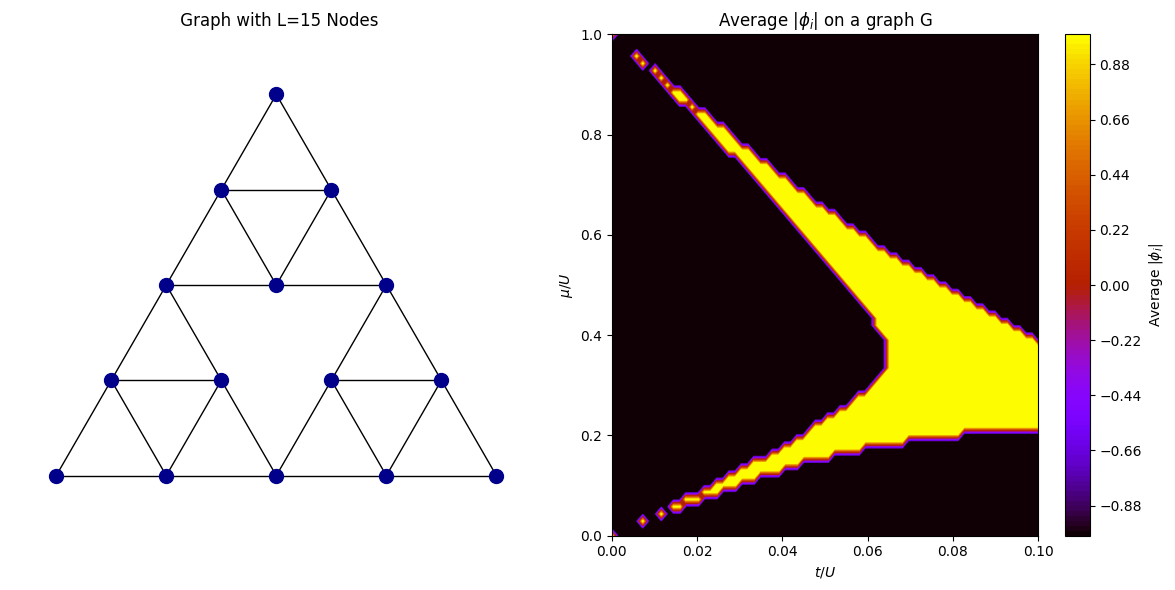

In [80]:
G,pos = sierpinski_triangle(2)

diagS2=phaseDiagramDataParallel_H_tuple(G,4,4,point_number=70,max_iterations=1)
phaseDiagramPlotter(diagS2,G,pos,binarize=True)

Starting calculation for 20 points of a size 15 sites
Basis of size 141936 generated in 2.6745 s
H of size 141936 generated in 107.0863 s
H of size 141936 solved in 3.7325 s
1 0.03 seconds
2 2.70 seconds
Energy = -15.279378712578193
2.5 2.70 seconds
3 4.71 seconds
Phi calculated in  4.7799 s, phi = 0.0002955860008048599


Processing:   0%|          | 0/400 [00:00<?, ?it/s]

Calculation completed in 754.93 seconds


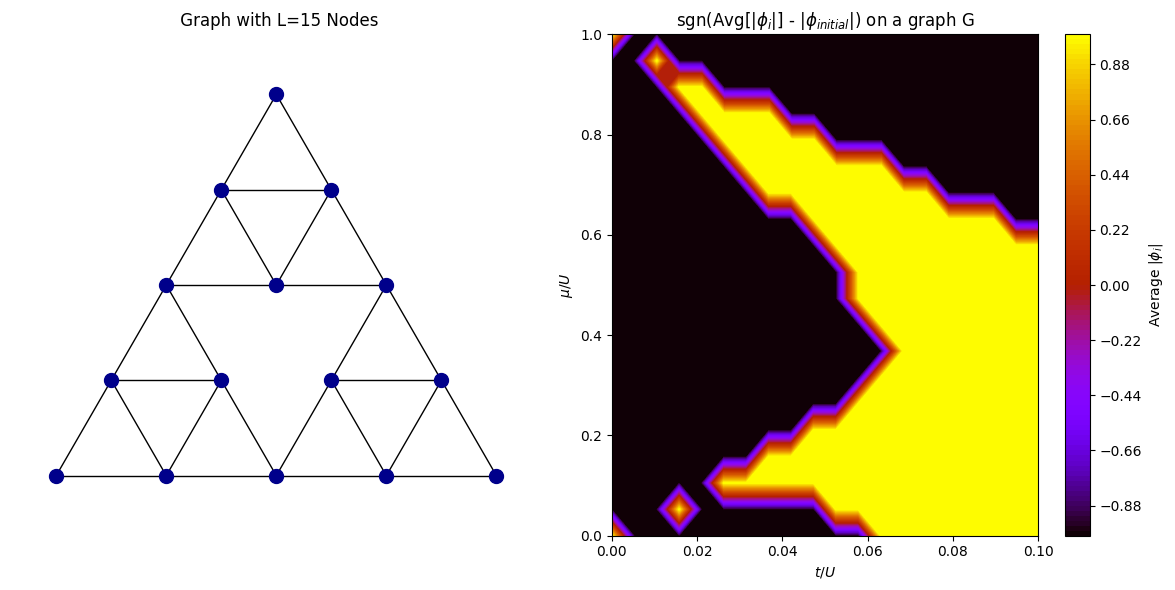

In [76]:
G,pos = sierpinski_triangle(2)

diagS2=phaseDiagramDataParallel_H_tuple(G,4,4,point_number=20,max_iterations=1)
phaseDiagramPlotter(diagS2,G,pos,binarize=True)

Starting calculation for 30 points of a size 15 sites
Basis of size 141936 generated in 2.5794 s
H of size 141936 generated in 104.9160 s
H of size 141936 solved in 2.4555 s
1 0.02 seconds
2 2.76 seconds
Energy = -15.279378712578188
2.5 2.76 seconds
3 4.64 seconds
Phi calculated in  4.7029 s, phi = 0.00028945068771344036


Processing:   0%|          | 0/900 [00:00<?, ?it/s]

Calculation completed in 1285.66 seconds


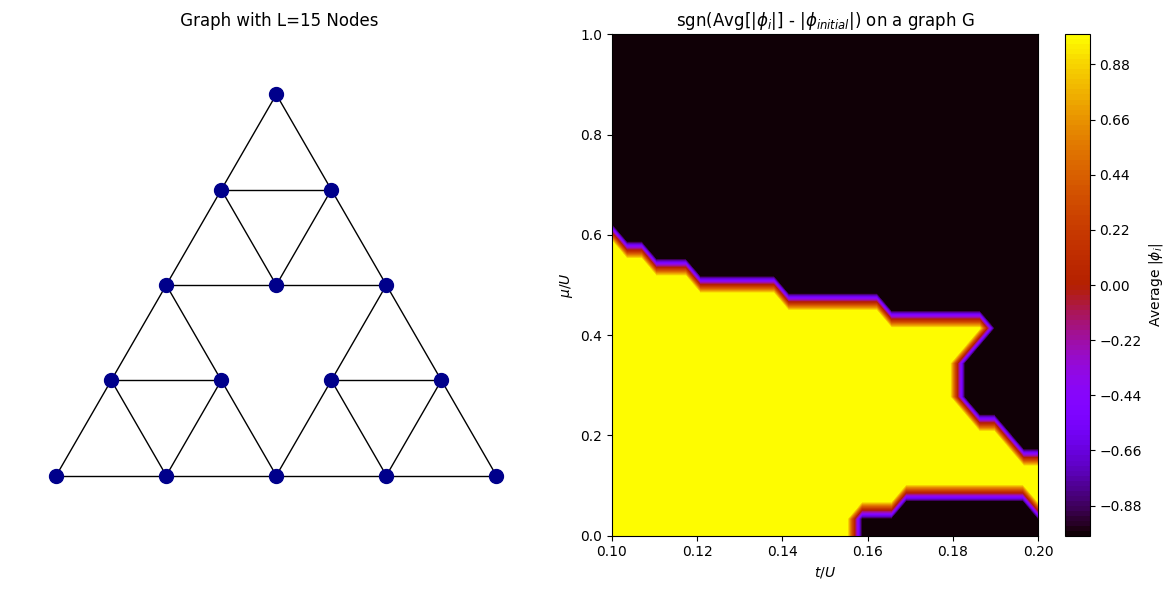

In [77]:
G,pos = sierpinski_triangle(2)

diagS2=phaseDiagramDataParallel_H_tuple(G,1,4,point_number=30,max_iterations=1,J_min=0.1,max_J=0.2)
phaseDiagramPlotter(diagS2,G,pos,binarize=True)

In [ ]:
G,pos = sierpinski_triangle(2)

diagS2=phaseDiagramDataParallel_H_tuple(G,1,4,point_number=15,point_number_J=30,max_iterations=1,max_J=0.3,N_minus=-5,N_plus=5,max_loc_flucs=3)
phaseDiagramPlotter(diagS2,G,pos,binarize=True)

Starting calculation for 15 points of a size 15 sites
Basis of size 180542 generated in 9.9074 s
H of size 180542 generated in 163.4093 s
H of size 180542 solved in 2.9088 s
1 0.03 seconds
2 3.10 seconds
Energy = -15.385248876620158
2.5 3.10 seconds
3 5.28 seconds
Phi calculated in  5.3787 s, phi = 0.0007004478659221403


Processing:   0%|          | 0/450 [00:00<?, ?it/s]

Starting calculation for 50 points of a size 16 sites
Basis of size 132953 generated in 2.2849 s
H of size 132953 generated in 99.2421 s
H of size 132953 solved in 0.5678 s
1 0.02 seconds
2 0.56 seconds
Energy = -16.000463551696527
2.5 0.57 seconds
3 1.65 seconds
Phi calculated in  1.6798 s, phi = 4.0616066934852586e-07


Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Calculation completed in 1345.63 seconds


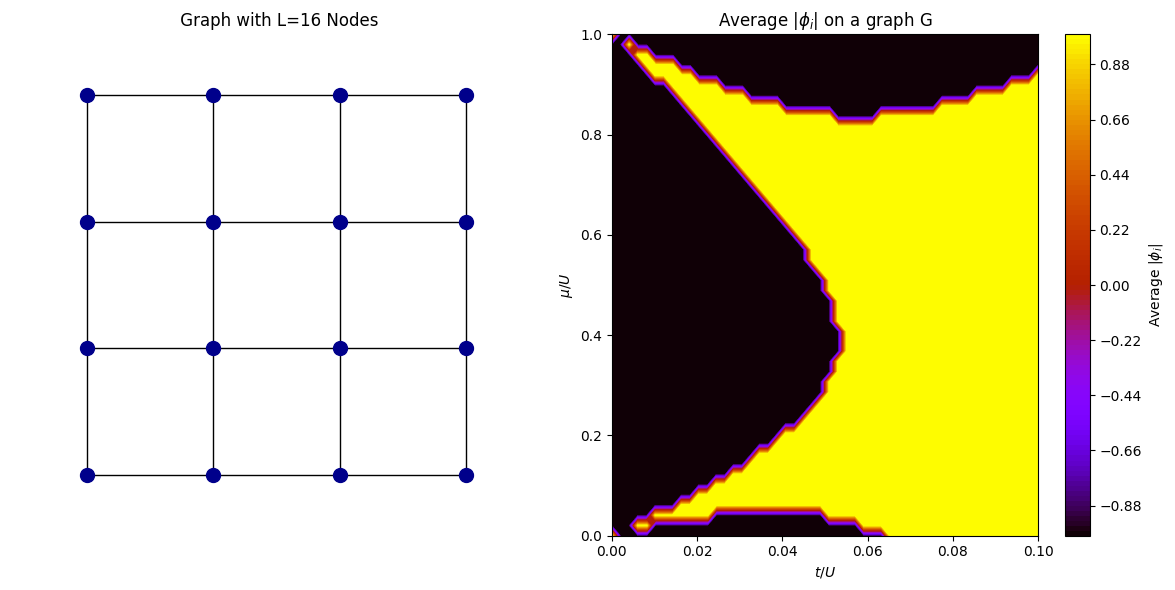

In [79]:
G,pos = gridGraph((4,4))

diag44=phaseDiagramDataParallel_H_tuple(G,5,4,point_number=50,max_iterations=1)
phaseDiagramPlotter(diag44,G,pos,binarize=True)

[(0, 0), (0.25, 0.0), (0.125, 0.2165), (0.5, 0.0), (0.375, 0.2165), (0.25, 0.433), (0.75, 0.0), (0.625, 0.2165), (1, 0), (0.875, 0.2165), (0.75, 0.433), (0.5, 0.433), (0.375, 0.6495), (0.625, 0.6495), (0.5, 0.866)]


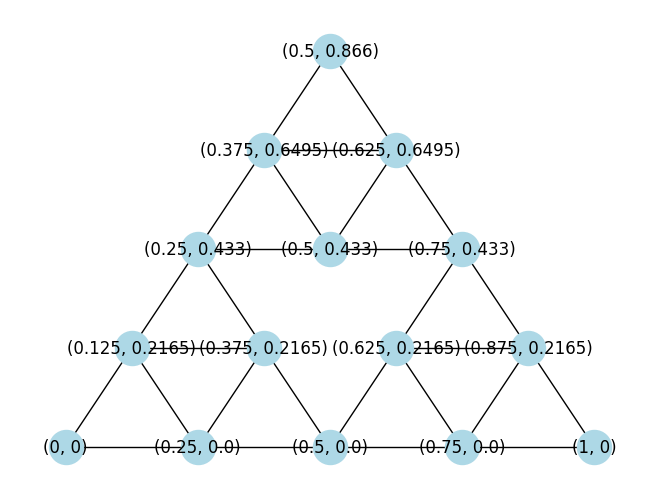

In [15]:
G,pos = sierpinski_triangle(2)
print([g for g in G.nodes()])
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=600)
plt.show()

diagS2=phaseDiagramDataParallel_H_tuple(G,4,4,point_number=20)

Starting calculation for 50 points of a size 9 sites
Basis of size 6211 generated in 0.0630 s
H of size 6211 generated in 1.4745 s
H of size 6211 solved in 0.0343 s
1 0.00 seconds
2 0.04 seconds
Energy = -8.98817233929894
2.5 0.04 seconds
3 0.09 seconds
Phi calculated in  0.0884 s, phi = 8.415477242847652e-08


Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Calculation completed in 30.78 seconds


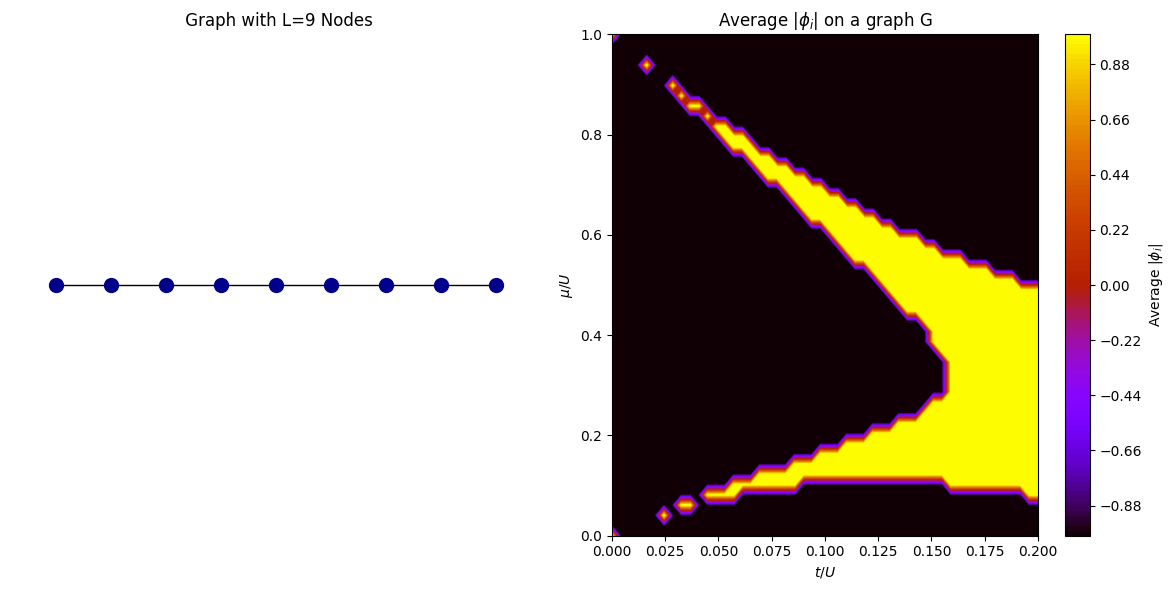

In [86]:
G,pos = gridGraph((1,9))

diag19=phaseDiagramDataParallel_H_tuple(G,4,2,point_number=50,max_iterations=1,max_J=0.2)
phaseDiagramPlotter(diag19,G,pos,binarize=True)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


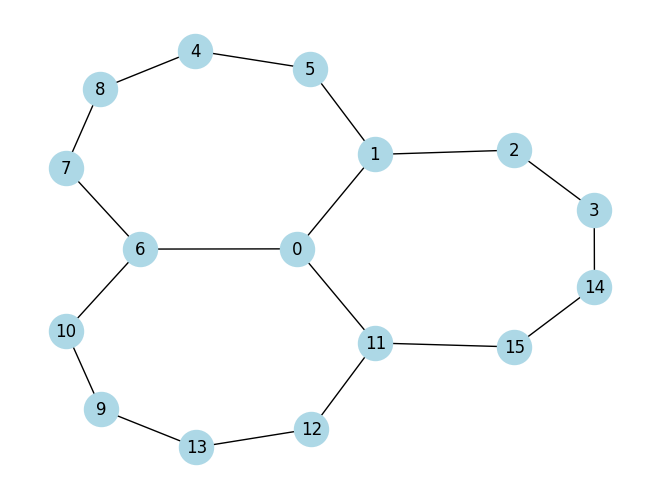

In [89]:
G,pos = hypGraph(7,3,2,vertexCenter=True)
print([g for g in G.nodes()])
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=600)
plt.show()

[0, 1, 2, 3, 4, 5, 6]


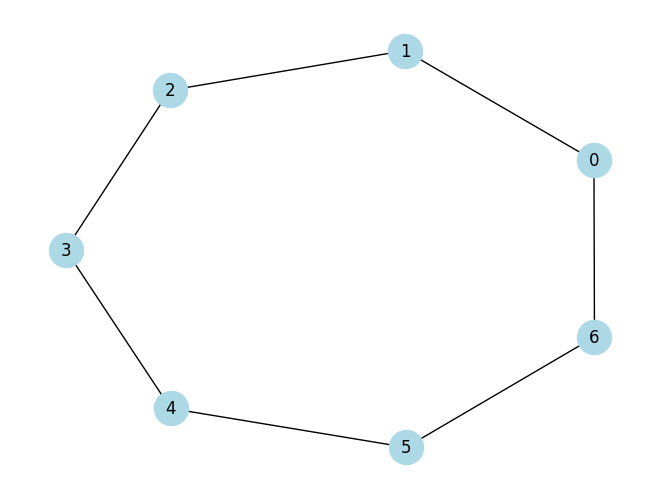

In [91]:
G,pos = hypGraph(7,3,1,vertexCenter=False)
print([g for g in G.nodes()])
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=600)
plt.show()

Starting calculation for 70 points of a size 16 sites
Basis of size 132953 generated in 2.2456 s
H of size 132953 generated in 81.1655 s
H of size 132953 solved in 0.5870 s
1 0.02 seconds
2 0.57 seconds
Energy = -15.95530205123237
2.5 0.57 seconds
3 1.67 seconds
Phi calculated in  1.6925 s, phi = 5.027739781189258e-07


Processing:   0%|          | 0/70 [00:00<?, ?it/s]

Calculation completed in 2575.11 seconds


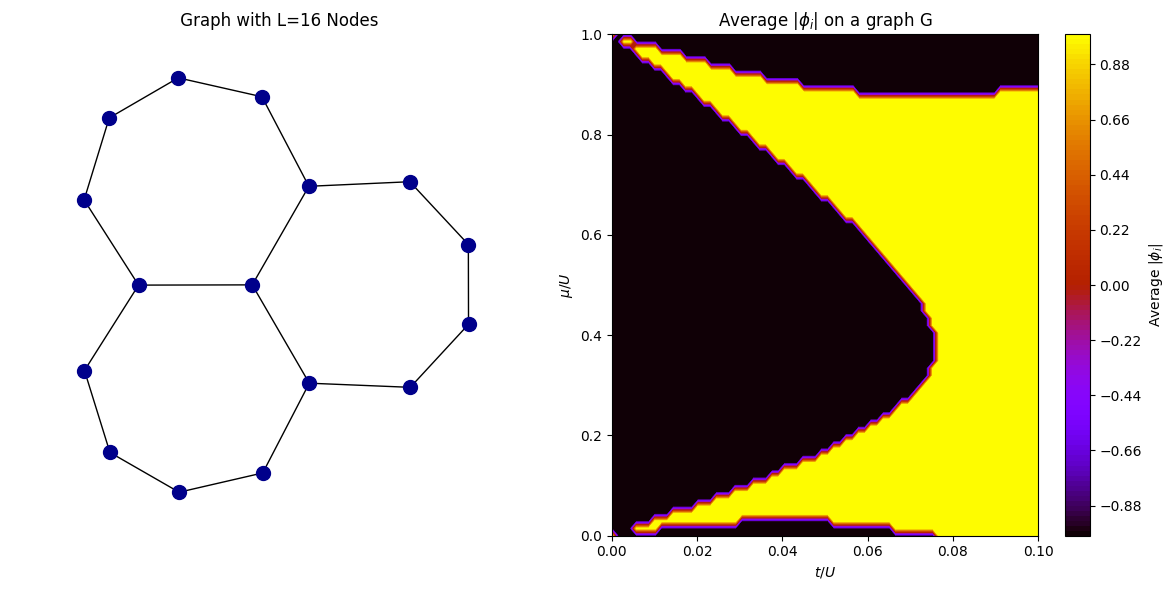

In [11]:
G,pos = hypGraph(7,3,2,vertexCenter=True)

diag73A=phaseDiagramDataParallel_H_tuple(G,0,3,point_number=70,max_iterations=1,max_J=0.1)
phaseDiagramPlotter(diag73A,G,pos,binarize=True)

Starting calculation for 100 points of a size 7 sites
Basis of size 1604 generated in 0.0155 s
H of size 1604 generated in 0.4832 s
H of size 1604 solved in 0.0219 s
1 0.00 seconds
2 0.02 seconds
Energy = -7.010747653082599
2.5 0.02 seconds
3 0.03 seconds
Phi calculated in  0.0318 s, phi = 6.447256839192942e-07


Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Calculation completed in 29.68 seconds


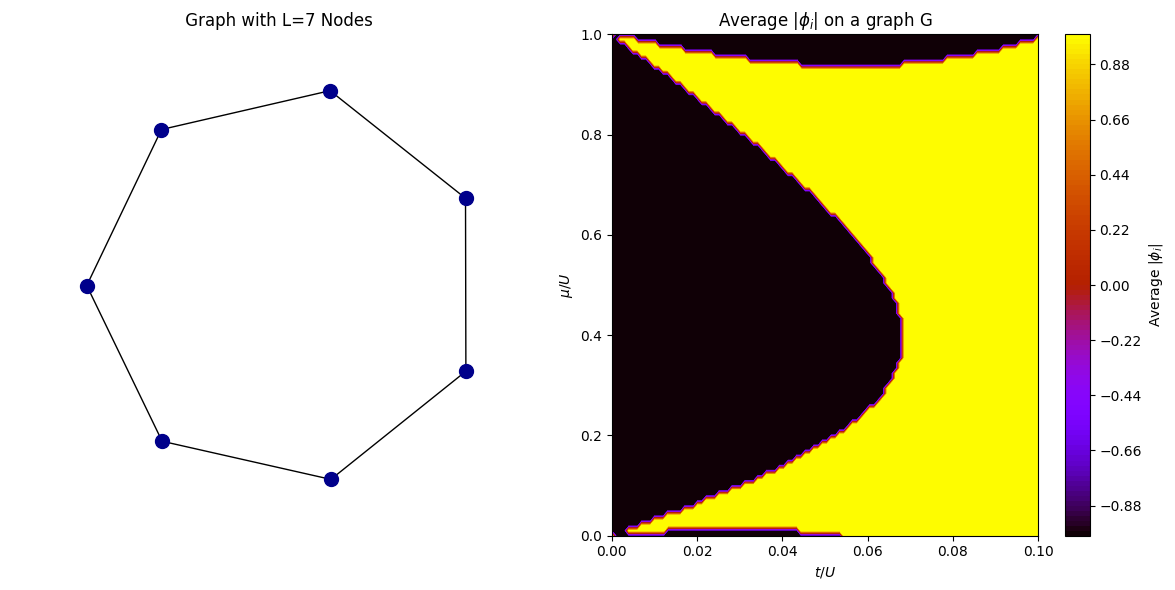

In [10]:
G,pos = hypGraph(7,3,1,vertexCenter=False)

diag73B=phaseDiagramDataParallel_H_tuple(G,0,3,point_number=100,max_iterations=1,max_J=0.1)
phaseDiagramPlotter(diag73B,G,pos,binarize=True)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


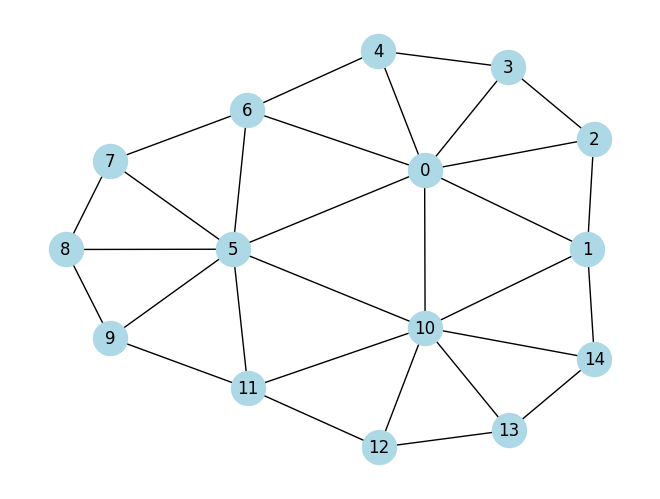

In [93]:
G,pos = hypGraph(3,7,2,vertexCenter=False)
print([g for g in G.nodes()])
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=600)
plt.show()

[0, 1, 2, 3, 4, 5, 6, 7]


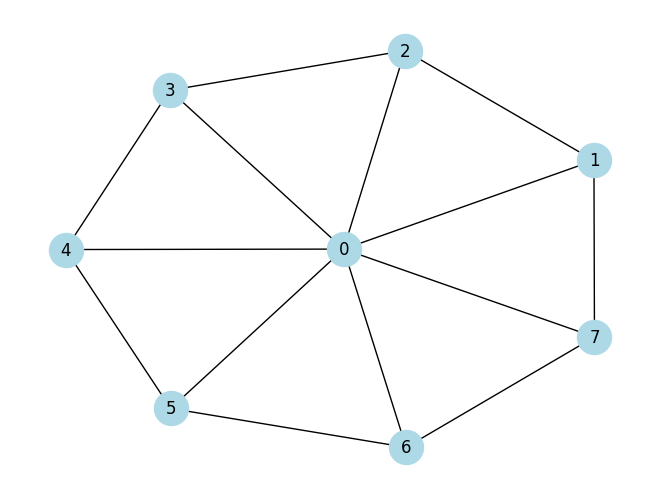

In [96]:
G,pos = hypGraph(3,7,2,vertexCenter=True)
print([g for g in G.nodes()])
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=600)
plt.show()

[0, 1, 2, 3, 4, 5, 6, 7]


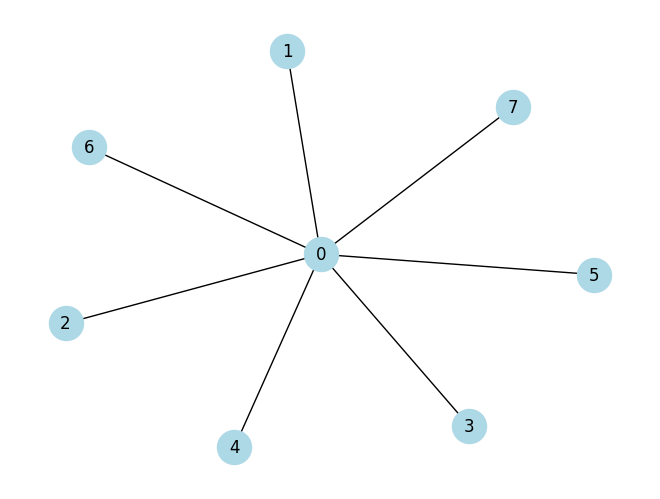

In [19]:
G,pos = tree_graph(7,1)
print([g for g in G.nodes()])
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=600)
plt.show()

Starting calculation for 70 points of a size 8 sites
Basis of size 3293 generated in 0.0330 s
H of size 3293 generated in 0.9668 s
H of size 3293 solved in 0.0216 s
1 0.00 seconds
2 0.02 seconds
Energy = -8.025100869905934
2.5 0.02 seconds
3 0.05 seconds
Phi calculated in  0.0453 s, phi = 3.7923265636923194e-06


Processing:   0%|          | 0/70 [00:00<?, ?it/s]

Calculation completed in 34.96 seconds


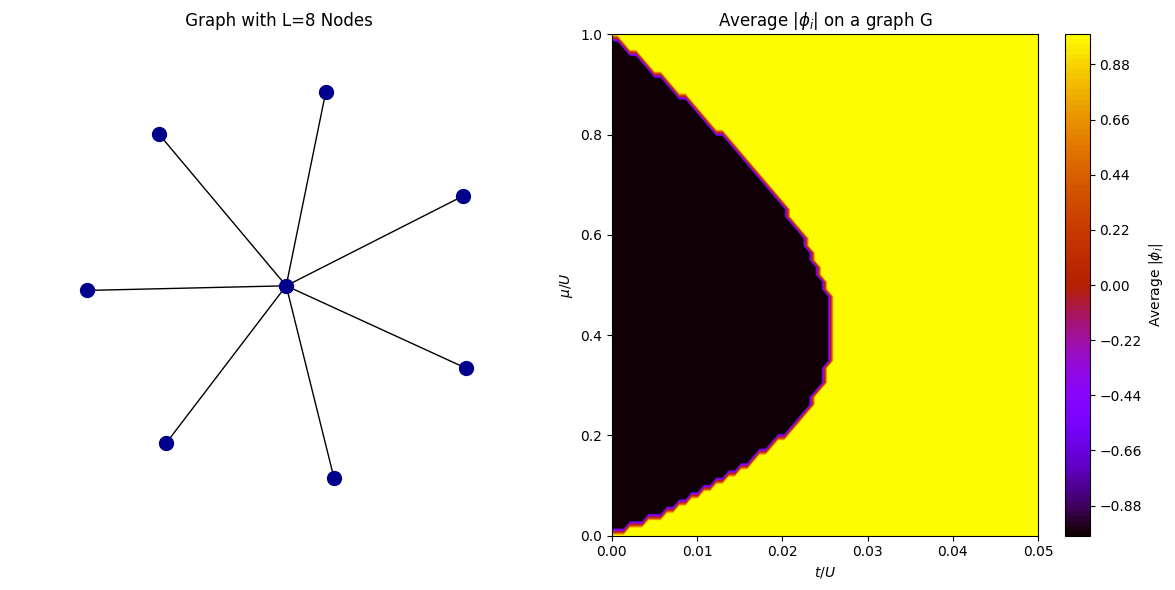

In [20]:
G,pos = tree_graph(7,1)

diagT7=phaseDiagramDataParallel_H_tuple(G,0,7,point_number=70,max_iterations=1,max_J=0.05)
phaseDiagramPlotter(diagT7,G,pos,binarize=True)

Starting calculation for 70 points of a size 8 sites
Basis of size 3293 generated in 0.0323 s
H of size 3293 generated in 1.4060 s
H of size 3293 solved in 0.0252 s
1 0.00 seconds
2 0.02 seconds
Energy = -8.090913118946425
2.5 0.02 seconds
3 0.05 seconds
Phi calculated in  0.0461 s, phi = 1.6200999064503234e-06


Processing:   0%|          | 0/70 [00:00<?, ?it/s]

Calculation completed in 31.00 seconds


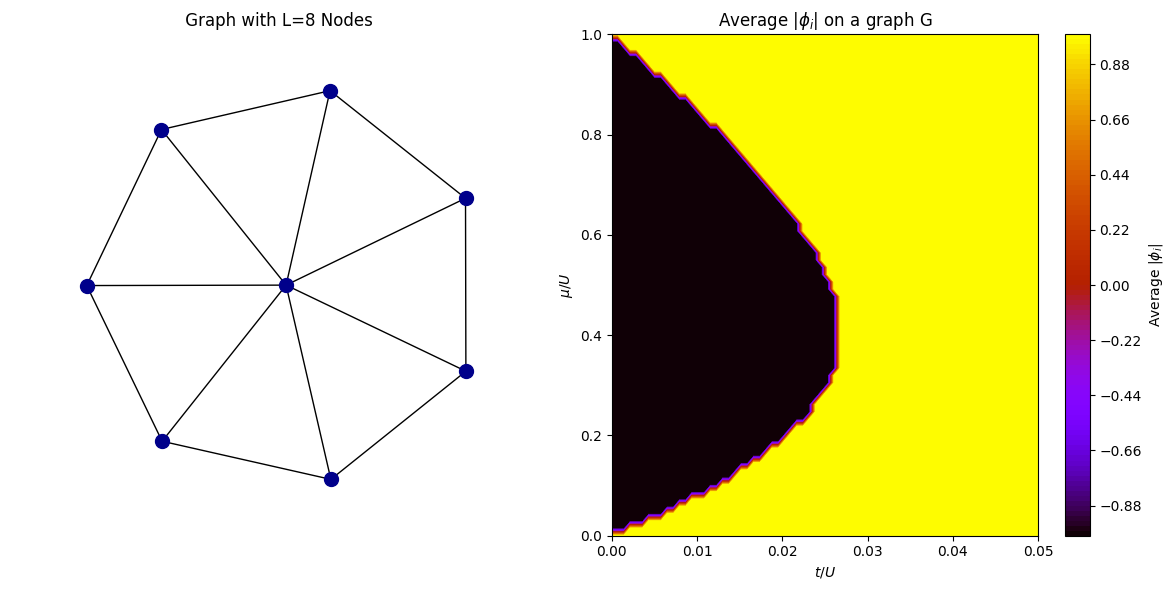

In [99]:
G,pos = hypGraph(3,7,2,vertexCenter=True)

diag37A=phaseDiagramDataParallel_H_tuple(G,0,7,point_number=70,max_iterations=1,max_J=0.05)
phaseDiagramPlotter(diag37A,G,pos,binarize=True)

Starting calculation for 50 points of a size 15 sites
Basis of size 94636 generated in 1.5209 s
H of size 94636 generated in 78.0849 s
H of size 94636 solved in 0.3394 s
1 0.01 seconds
2 0.35 seconds
Energy = -15.083127144564209
2.5 0.35 seconds
3 1.11 seconds
Phi calculated in  1.1335 s, phi = 1.0488120723328613e-06


Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Calculation completed in 980.24 seconds


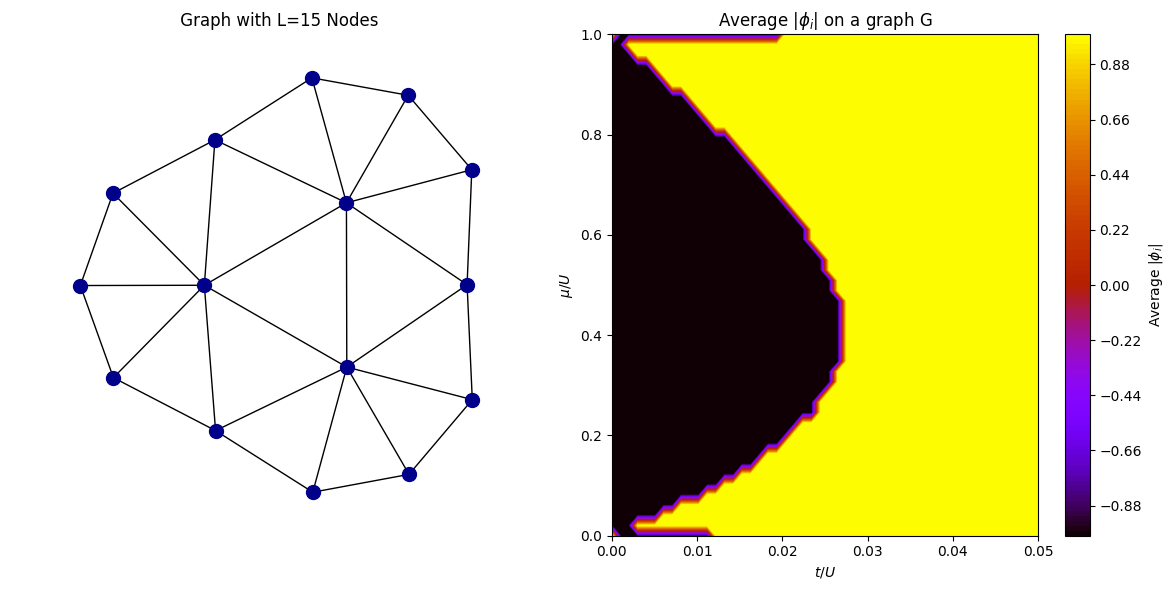

In [100]:
G,pos = hypGraph(3,7,2,vertexCenter=False)

diag37B=phaseDiagramDataParallel_H_tuple(G,0,7,point_number=50,max_iterations=1,max_J=0.05)
phaseDiagramPlotter(diag37B,G,pos,binarize=True)

In [ ]:
###function graveyard


def hamFull2(adMat,N, J, mu, niu, phi, vbasisGen_args=()):
    M = adMat.shape[0]
    vList = vbasisGen(N,M,*vbasisGen_args)
    vList = np.vstack((vList, vbasisGen(N+1,M,*vbasisGen_args)))
    vList = np.vstack((vList, vbasisGen(N-1,M,*vbasisGen_args)))

    
    Tsort, ind = TtagL(vList)#debug

    #we make a dictionary so that: vList[vDict[str(v)]] == v
    vDict = {}
    for i,v in enumerate(vList):
        vDict[str(v)] = i
    
    xs, ys = adMat.nonzero()
    ham_kin = lil_matrix((vList.shape[0],vList.shape[0]))
    for i in range(vList.shape[0]):
        v = vList[i]
        for x,y in np.transpose([xs,ys]):
            if x!=y and v[y]>0:
                newV = v.copy()
                newV[x] += 1
                newV[y] -= 1
                newIdx = vDict.get(str(newV))
                
                newT = Ttag(newV)
                newIdx2 = np.searchsorted(Tsort, newT, side='left')
                if newIdx is not None:
                    ham_kin[i,newIdx] = -J*np.sqrt((v[x]+1)*v[y])
    ham_int = lil_matrix((vList.shape[0],vList.shape[0]))
    for i in range(vList.shape[0]):
        v = vList[i]
        ham_int[i,i] = U/2*np.sum((v-1)*v) - mu*np.sum(v)
    
    ham_MF = lil_matrix((vList.shape[0],vList.shape[0]))
    for site_idx, site_niu in enumerate(niu):
        if site_niu==0: pass
        else:
            for i in range(vList.shape[0]):
                v = vList[i]

                #add particle from bulk
                newV = v.copy()
                newV[site_idx] += 1
                newIdx = vDict.get(str(newV))
                if newIdx is not None:
                #if abs(np.sum(newV)-N)<=1:
                    ham_MF[i,newIdx] = -J*site_niu*np.sqrt((v[site_idx]+1))*phi

                #remove particle from bulk
                newV = v.copy()
                newV[site_idx] -= 1
                newIdx = vDict.get(str(newV))
                if newIdx is not None:
                #if abs(np.sum(newV)-N)<=1:
                    ham_MF[i,newIdx] = -J*site_niu*np.sqrt((v[site_idx]))*np.conj(phi)

    ham = ham_kin + ham_int + ham_MF
    return ham.tocsr(), vList